In [53]:
# ignore warnings 
import warnings
warnings.filterwarnings('ignore')
import os
from dotenv import load_dotenv
import numpy as np
import pandas as pd
import ast
from bisect import bisect_left
# import Counter
from collections import Counter

from scipy.signal import find_peaks
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
load_dotenv()
# base_dir = os.getenv("BASE_DIR")
base_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(base_dir, "data")
behav_data_dir = os.path.join(data_dir, "behav")
stimuli_dir = os.path.join(base_dir, "stimuli")

In [3]:
pavlovia_df = pd.read_excel(os.path.join(behav_data_dir, "pavlovia.xlsx"))
postsurvey_df = pd.read_csv(os.path.join(behav_data_dir, "postsurvey.csv"))
prolific_df = pd.read_csv(os.path.join(behav_data_dir, "prolific_ids.csv"))
print(pavlovia_df.shape, postsurvey_df.shape, prolific_df.shape)

(139, 3) (149, 29) (120, 19)


In [4]:
pp_ids = prolific_df["Participant id"].values
# select rows in pavlovia_df that have pp_ids in prolific_df
pavlovia_df2 = pavlovia_df[pavlovia_df["participant"].isin(pp_ids)]
# do the same for postsurvey_df
postsurvey_df2 = postsurvey_df[postsurvey_df["participant"].isin(pp_ids)]
postsurvey_df3 = postsurvey_df2[['ch1', 'ch2', 'ch3', 'recall', 'engagement', 'clarity', 'age', 'gender', 'participant']]
print(pavlovia_df2.shape, postsurvey_df3.shape)

(118, 3) (118, 9)


In [5]:
# merge the two dataframes based on the participant column
merged_df = pd.merge(pavlovia_df2, postsurvey_df3, on="participant")
print(merged_df.shape)

(118, 11)


In [6]:
# Remove BOM
merged_df['key_resp_2.rt'] = merged_df['key_resp_2.rt'].str.replace('\ufeff', '', regex=False)
# Convert string representation of lists to actual lists
merged_df['event_seg'] = merged_df['key_resp_2.rt'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)
# Filter elements with exactly 3 digits after the decimal point using NumPy
merged_df['event_seg'] = merged_df['event_seg'].apply(
    lambda x: np.around(x, decimals=3)
)

## Resample seconds to TRs (Bin methods)

In our pavlovia experiment, the stimulus was presented in the same way as it was in the fmri scanner—began with 18 seconds of neutral introductory music followed by 3 seconds of silence, such that the story started at 0:21 (after 14 TRs) and ended at 11:37, for a duration of 676 seconds (~451 TRs)—except that we only added 5 seconds (~3 TRs) instead of 15 seconds (10 TRs) of silence at the end of the story.

So our pavlovia stimulus is 21+676+5 = 702 seconds long, which is 468  TRs.

The bin method is that we want to convert anything between 0 and 1.5 to 1, anything between 1.5 and 3 to 2, and anything between 3 and 5 to 3, etc.

Mathematically speaking, we want to round up to the ceiling of the number divided by 1.5, and if someone pressed the space bar twice within a TR, we only count it once.

In [7]:
def seconds2TRs(resp_seconds):
    resp_seconds = np.array(resp_seconds)
    resp_TRs = np.ceil(resp_seconds / 1.5)
    resp_TRs = np.unique(resp_TRs)
    return resp_TRs

In [8]:
merged_df['event_seg_TRs'] = merged_df['event_seg'].apply(seconds2TRs)

In [9]:
merged_df.head()

participant  key_resp_1.rt  \
0  6070b8550e199cd6db5e4a79        28.7922   
1  60baaa995c09d3162511871d        64.8632   
2  6100943a3afefd2133a6f0f7        32.3460   
3  5cead89f7832f40018ca2245        48.7388   
4  6462aa815636e19bb0eefbd3        21.3484   

                                       key_resp_2.rt         ch1         ch2  \
0  [51.927900000035756,94.9035,178.6211,202.9921,...         Lee      Arthur   
1  [83.0235999994278,119.187,132.3696,189.632,242...  Don't know      Arthur   
2  [28.583,32.491,35.375,41.56,50.441,59.726,66.1...         Lee      Arthur   
3  [52.22260000038148,81.6475,98.1323,222.1914,23...  Don't know  Don't know   
4  [42.076600000023845,51.4786,76.2976,87.1831,10...         Lee      Arthur   

          ch3                                             recall engagement  \
0        Mary  Lee and Mary were sitting close together, appa...          7   
1  Don't know  This story was incredibly hard for me to follo...          4   
2  Don't know  The story takes place in New York City. An old...          7   
3  Don't know  I remember that there's a grey haired man and ...          7   
4      Joanie  Lee was at home with the young girl. I don't k...          7   

  clarity              age  gender  \
0       9  25-34 years old  Female   
1       7  35-44 years old    Male   
2       6  18-24 years old  Female   
3       4  25-34 years old  Female   
4       7  45-54 years old  Female   

                                           event_seg  \
0  [51.928, 94.904, 178.621, 202.992, 241.176, 28...   
1  [83.024, 119.187, 132.37, 189.632, 242.675, 25...   
2  [28.583, 32.491, 35.375, 41.56, 50.441, 59.726...   
3  [52.223, 81.648, 98.132, 222.191, 232.965, 299...   
4  [42.077, 51.479, 76.298, 87.183, 108.468, 123....   

                                       event_seg_TRs  
0  [35.0, 64.0, 120.0, 136.0, 161.0, 190.0, 204.0...  
1  [56.0, 80.0, 89.0, 127.0, 162.0, 169.0, 184.0,...  
2  [20.0, 22.0, 24.0, 28.0, 34.0, 40.0, 45.0, 47....  
3  [35.0, 55.0, 66.0, 149.0, 156.0, 200.0, 251.0,...  
4  [29.0, 35.0, 51.0, 59.0, 73.0, 83.0, 99.0, 108...

## Make some plots

### Counts of key presses in both seconds and TRs

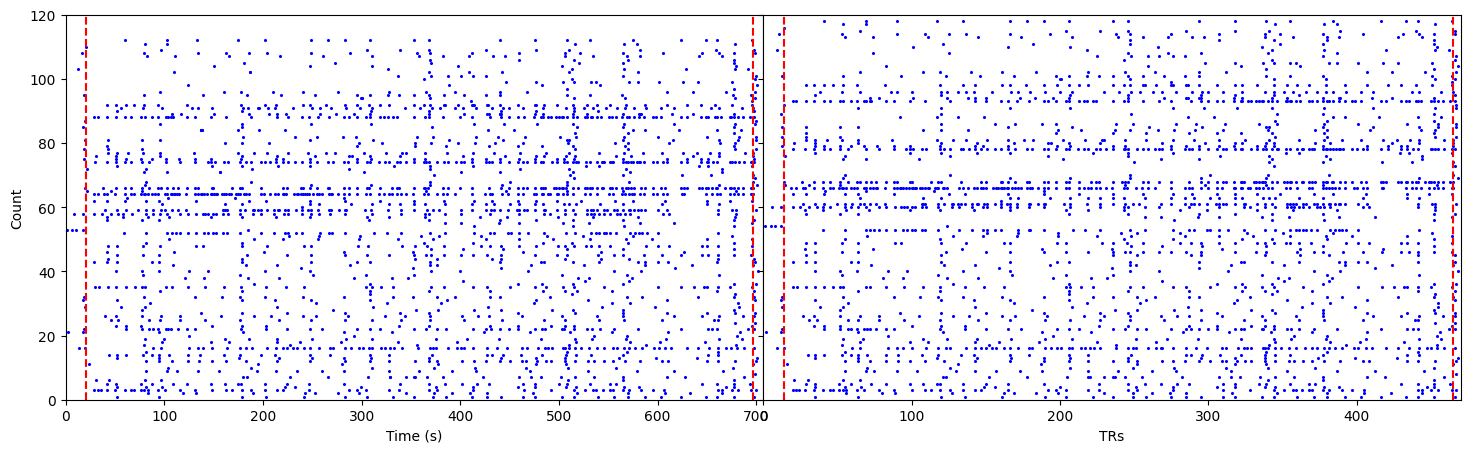

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5), sharey=True)

# Remove the space between the subplots
plt.subplots_adjust(wspace=0)

# Plot 1
y_value = 1
for i, row in enumerate(merged_df['event_seg']):
    if row is None or (isinstance(row, float) and np.isnan(row)):
        continue
    ax1.scatter(row, [y_value] * len(row), color='b', s=1.5)
    y_value += 1

ax1.set_xlim(0, 707)
ax1.set_ylim(0, 120)
ax1.axvline(x=21, color='r', linestyle='--')
ax1.axvline(x=697, color='r', linestyle='--')
# set x label
ax1.set_xlabel("Time (s)")
# set y label
ax1.set_ylabel("Count")

# Plot 2
y_value = 1
for i, row in enumerate(merged_df['event_seg_TRs']):
    if row is None or (isinstance(row, float) and np.isnan(row)):
        continue
    ax2.scatter(row, [y_value] * len(row), color='b', s=1.5)
    y_value += 1

ax2.set_xlim(0, 470)
ax2.set_ylim(0, 120)
ax2.axvline(x=14, color='r', linestyle='--')
ax2.axvline(x=465, color='r', linestyle='--')
# set x label
ax2.set_xlabel("TRs")

plt.show()

## Get the aggreement on those key presses

In [75]:
def get_agreement(response_col, unit, df):
    all_responses = []
    for i, row in enumerate(df[response_col]):
        # Skip over None or NaN values
        if row is None or (isinstance(row, float) and np.isnan(row)):
            continue
        all_responses.extend(row)
    # Count the occurrences of each unique element
    response_counts = Counter(all_responses)
    # Create a new DataFrame
    agreement_df = pd.DataFrame(list(response_counts.items()), columns=[unit, 'count'])
    # drop nan based on TR
    agreement_df = agreement_df.dropna(subset=[unit])
    # Sort by TR for better readability
    agreement_df = agreement_df.sort_values(by=unit).reset_index(drop=True)
    agreement_df['agreement'] = agreement_df['count'] / df.shape[0]
    # remove the first 14 TRs/21s and the last 3 TRs
    if unit == 'TR':
        agreement_df = agreement_df[(agreement_df[unit] > 14)&(agreement_df[unit] < 467)]
    elif unit == 'second':
        agreement_df = agreement_df[(agreement_df[unit] > 21)&(agreement_df[unit] < 699)]
    else:
        print("Please enter a valid unit: TR or second")
    # reset index
    agreement_df = agreement_df.reset_index(drop=True)
    return agreement_df

In [76]:
agree_TR_df = get_agreement('event_seg_TRs', 'TR', merged_df)
agree_TR_df.describe()

TR       count   agreement
count  409.000000  409.000000  409.000000
mean   243.051345    5.161369    0.043740
std    128.380332    4.488370    0.038037
min     15.000000    1.000000    0.008475
25%    133.000000    2.000000    0.016949
50%    245.000000    4.000000    0.033898
75%    352.000000    7.000000    0.059322
max    466.000000   27.000000    0.228814

## Get duration for each event in a given agreement threshold

In [77]:
for th in np.arange(0.1, 0.23, 0.01):
    n_event = agree_TR_df[agree_TR_df['agreement'] > th].shape[0]
    print(f"There are {n_event} events above agreement threshold {th}")

There are 44 events above agreement threshold 0.1
There are 32 events above agreement threshold 0.11
There are 20 events above agreement threshold 0.12
There are 17 events above agreement threshold 0.13
There are 15 events above agreement threshold 0.13999999999999999
There are 11 events above agreement threshold 0.14999999999999997
There are 9 events above agreement threshold 0.15999999999999998
There are 4 events above agreement threshold 0.16999999999999998
There are 2 events above agreement threshold 0.17999999999999997
There are 2 events above agreement threshold 0.18999999999999995
There are 2 events above agreement threshold 0.19999999999999996
There are 1 events above agreement threshold 0.20999999999999996
There are 1 events above agreement threshold 0.21999999999999995


from the above result, we can stop our threshold at 0.15

There are 44 events above agreement threshold 0.1
1.0     14
2.0      4
15.0     3
11.0     3
10.0     3
23.0     2
22.0     2
5.0      2
17.0     2
50.0     1
6.0      1
12.0     1
9.0      1
28.0     1
18.0     1
4.0      1
54.0     1
7.0      1
Name: count, dtype: int64
count    44.000000
mean     10.272727
std      12.035536
min       1.000000
25%       1.000000
50%       6.500000
75%      15.000000
max      54.000000
dtype: float64


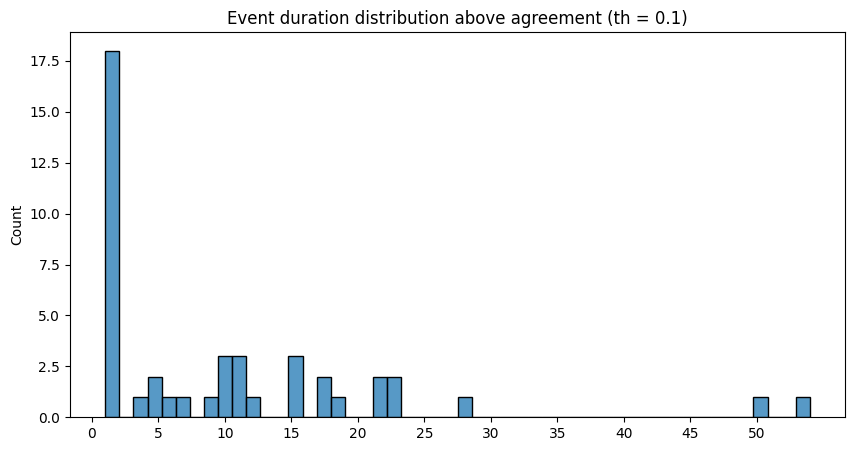

There are 32 events above agreement threshold 0.11
1.0     8
10.0    4
17.0    2
2.0     2
23.0    2
20.0    1
7.0     1
54.0    1
3.0     1
22.0    1
4.0     1
15.0    1
18.0    1
28.0    1
6.0     1
30.0    1
46.0    1
56.0    1
11.0    1
Name: count, dtype: int64
count    32.000000
mean     14.125000
std      15.222543
min       1.000000
25%       1.750000
50%      10.000000
75%      20.500000
max      56.000000
dtype: float64


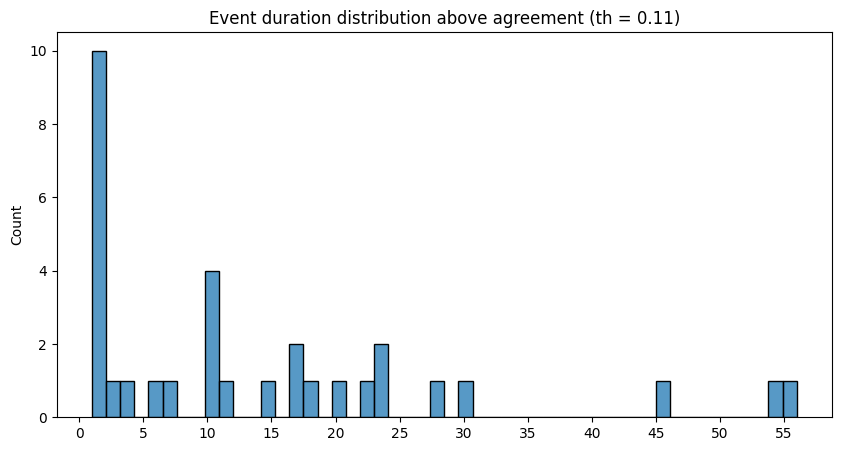

There are 20 events above agreement threshold 0.12
1.0     2
21.0    1
24.0    1
12.0    1
11.0    1
61.0    1
3.0     1
33.0    1
5.0     1
20.0    1
47.0    1
29.0    1
10.0    1
30.0    1
17.0    1
23.0    1
46.0    1
56.0    1
2.0     1
Name: count, dtype: int64
count    20.000000
mean     22.600000
std      18.405949
min       1.000000
25%       8.750000
50%      20.500000
75%      30.750000
max      61.000000
dtype: float64


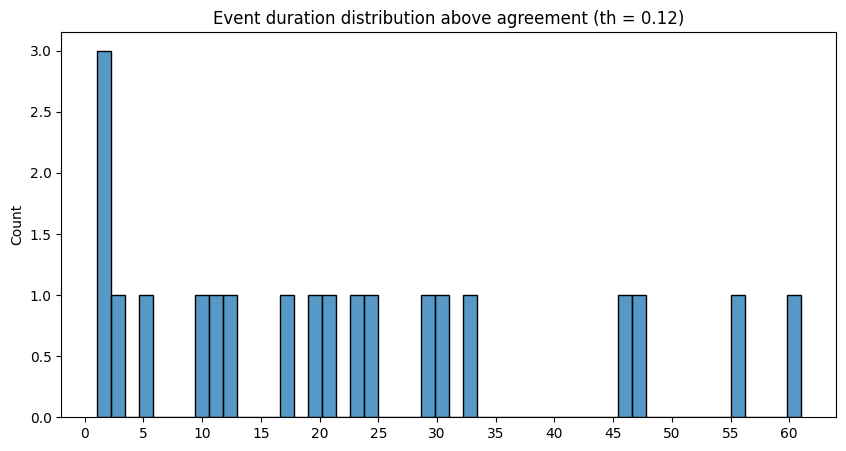

There are 17 events above agreement threshold 0.13
1.0     2
21.0    1
29.0    1
56.0    1
46.0    1
23.0    1
17.0    1
30.0    1
10.0    1
71.0    1
20.0    1
5.0     1
33.0    1
64.0    1
11.0    1
14.0    1
Name: count, dtype: int64
count    17.000000
mean     26.588235
std      21.366033
min       1.000000
25%      11.000000
50%      21.000000
75%      33.000000
max      71.000000
dtype: float64


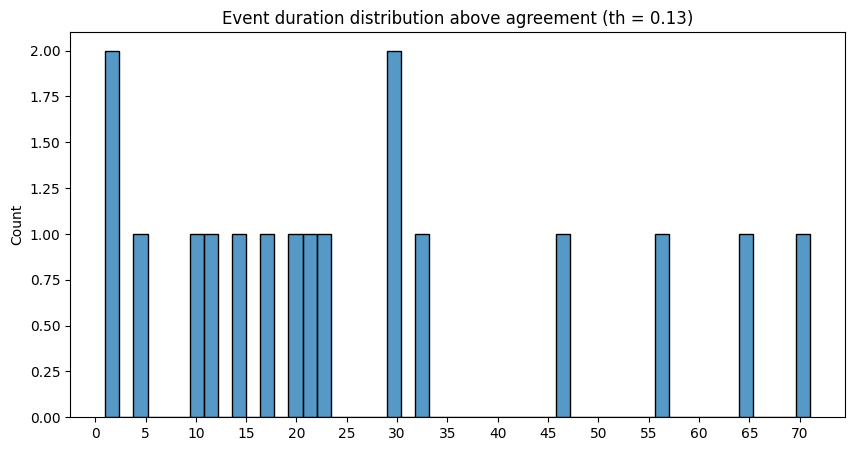

There are 15 events above agreement threshold 0.14
21.0    1
29.0    1
56.0    1
46.0    1
23.0    1
17.0    1
30.0    1
10.0    1
72.0    1
20.0    1
5.0     1
34.0    1
64.0    1
11.0    1
14.0    1
Name: count, dtype: int64
count    15.000000
mean     30.133333
std      20.545652
min       5.000000
25%      15.500000
50%      23.000000
75%      40.000000
max      72.000000
dtype: float64


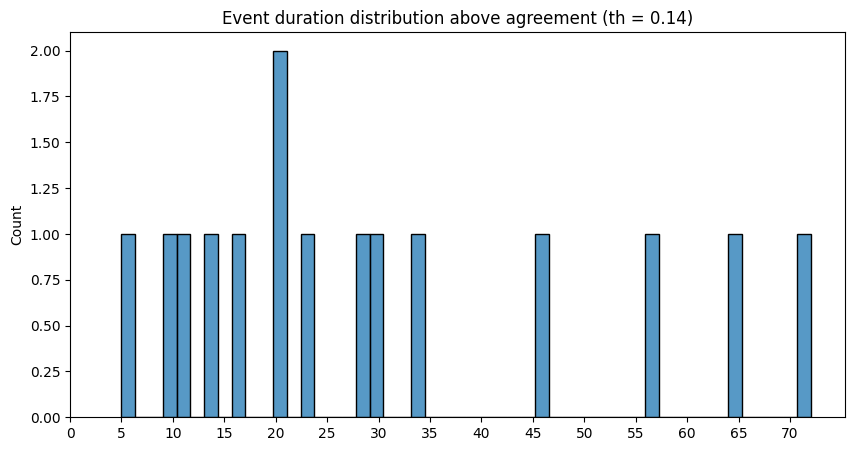

There are 11 events above agreement threshold 0.15
152.0    1
40.0     1
30.0     1
10.0     1
72.0     1
20.0     1
5.0      1
34.0     1
64.0     1
11.0     1
14.0     1
Name: count, dtype: int64
count     11.000000
mean      41.090909
std       42.788911
min        5.000000
25%       12.500000
50%       30.000000
75%       52.000000
max      152.000000
dtype: float64


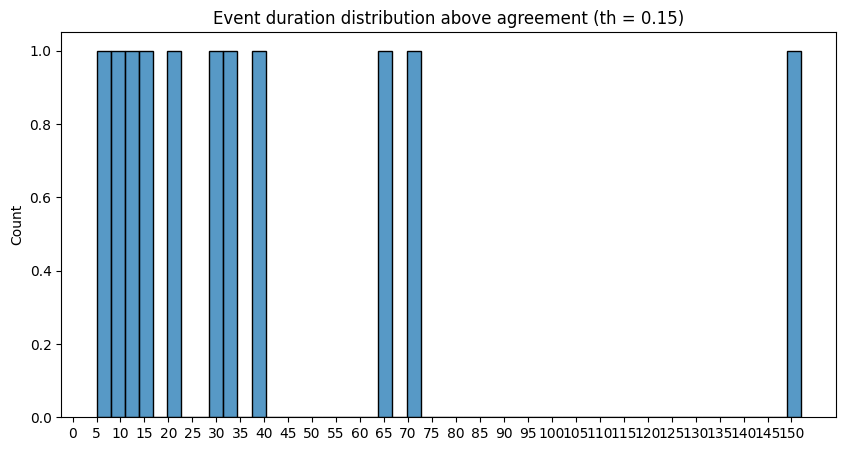

In [78]:
for th in [0.1, 0.11, 0.12, 0.13, 0.14, 0.15]:
    n_event = agree_TR_df[agree_TR_df['agreement'] > th].shape[0]
    print(f"There are {n_event} events above agreement threshold {th}")
    temp_df = agree_TR_df[agree_TR_df['agreement'] > th]
    temp_df["duration"] = temp_df["TR"].diff()
    # fill the first row with TR - 14
    temp_df["duration"].iloc[0] = temp_df["TR"].iloc[0] - 14
    duration = temp_df["duration"].values
    # add another value to the end of the array using 465 - TR if TR is < 465
    if temp_df["TR"].iloc[-1] < 465:
        duration = np.append(duration, 465 - temp_df["TR"].iloc[-1])
    # make a description of the duration using pd.describe
    print(pd.Series(duration).value_counts())
    print(pd.Series(duration).describe())
    # plot histogram using seaborn on duration
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.histplot(duration, bins=50)
    plt.title(f"Event duration distribution above agreement (th = {th})")
    # set x-ticks as multiples of 5
    plt.xticks(np.arange(0, np.max(duration), 5))
    plt.show()

## Method 1: Filter out small events

For any set of “boundaries” that exceed the threshold, if they’re within X TRs, place the boundary at the TR with the highest agreement (X = 1, 2, 3) 
we need to do this for th=0.1, 0.11, 0.12, 0.13 (events above those thresholds have minimum 5TRs).

In [79]:
def filter_by_eth(agreement_df, eth):
    for th in [0.1, 0.11, 0.12, 0.13, 0.14, 0.15]:
        n_event = agreement_df[agreement_df['agreement'] > th].shape[0]
        print(f"There are {n_event} events above agreement threshold {th}. \nAfter filtered by event length = {eth}:")
        temp_df = agreement_df[agreement_df['agreement'] > th]
        temp_df["duration"] = temp_df["TR"].diff()
        # reset index
        temp_df = temp_df.reset_index(drop=True)
        for i, row in enumerate(temp_df["duration"]):
            if i > 0:
                if row <= eth:
                    # check the agreement of the previous row and the current row
                    if temp_df["agreement"].iloc[i] >= temp_df["agreement"].iloc[i-1]:
                        # set a lable for the smaller agreement
                        temp_df.at[i-1, "label"] = 0
                    else:
                        temp_df.at[i, "label"] = 0
                else:
                    temp_df.at[i, "label"] = 1
        # get the new temp_df with lable != 0
        filtered_df = temp_df[temp_df["label"] != 0][["TR", "agreement"]]
        # reset index
        filtered_df = filtered_df.reset_index(drop=True)
        # add duration column
        filtered_df["duration"] = filtered_df["TR"].diff()
        print(filtered_df.describe())
        # plot agreement and TR
        sns.lineplot(data=filtered_df, x="TR", y="agreement", color="maroon")

        # Find the y-axis limits to calculate relative positions
        ymin, ymax = plt.ylim()

        # add vertical lines for TR, ymin=0, ymax=agreement
        for index in filtered_df.index:
            relative_ymax = (filtered_df['agreement'].iloc[index] - ymin) / (ymax - ymin)
            plt.axvline(x=filtered_df['TR'].iloc[index], color='darkslategray', ymin=0, ymax=relative_ymax, linewidth=1)

        plt.title(f"Boundaries filtered by event lenght = {eth} (agreement > {th})")
        sns.despine()
        plt.show()

### Event threshold = 1

There are 44 events above agreement threshold 0.1. 
After filtered by event length = 1:
               TR  agreement   duration
count   30.000000  30.000000  29.000000
mean   253.333333   0.138418  15.068966
std    139.446525   0.033408  12.682753
min     29.000000   0.101695   2.000000
25%    148.750000   0.110169   6.000000
50%    261.000000   0.135593  12.000000
75%    352.000000   0.161017  18.000000
max    466.000000   0.228814  54.000000


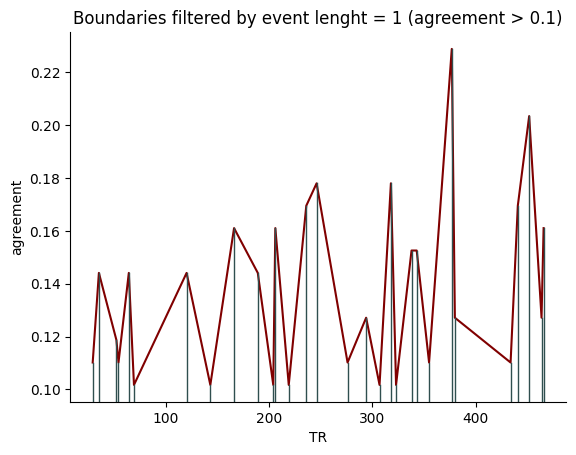

There are 32 events above agreement threshold 0.11. 
After filtered by event length = 1:
               TR  agreement   duration
count   24.000000  24.000000  23.000000
mean   263.958333   0.147599  19.000000
std    147.987508   0.031104  15.509528
min     29.000000   0.110169   2.000000
25%    154.500000   0.125000   8.500000
50%    285.000000   0.144068  17.000000
75%    377.750000   0.163136  23.500000
max    466.000000   0.228814  56.000000


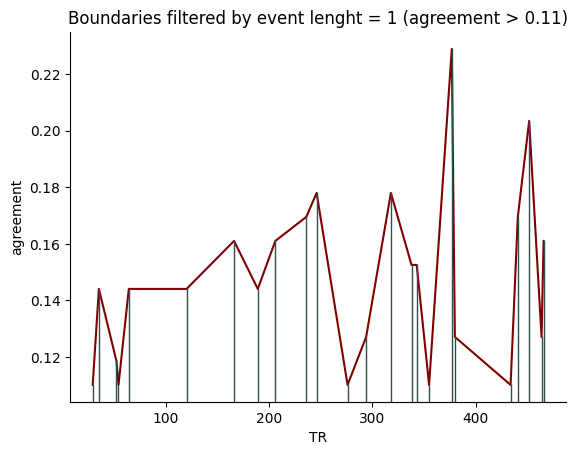

There are 20 events above agreement threshold 0.12. 
After filtered by event length = 1:
               TR  agreement   duration
count   18.000000  18.000000  17.000000
mean   285.277778   0.159605  25.352941
std    135.898667   0.026362  18.445667
min     35.000000   0.127119   2.000000
25%    193.250000   0.144068  11.000000
50%    306.000000   0.156780  23.000000
75%    379.250000   0.169492  34.000000
max    466.000000   0.228814  61.000000


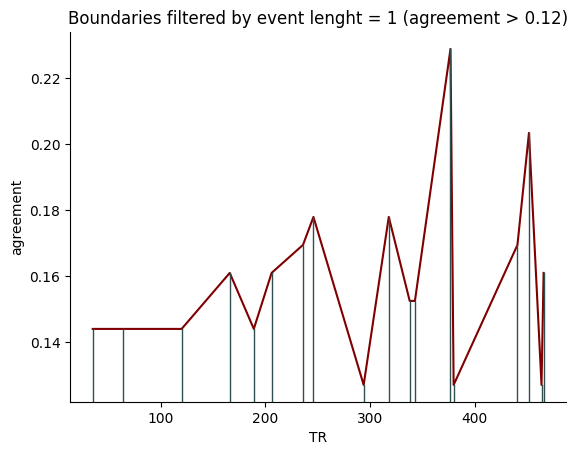

There are 17 events above agreement threshold 0.13. 
After filtered by event length = 1:
               TR  agreement   duration
count   15.000000  15.000000  14.000000
mean   266.466667   0.166102  30.785714
std    138.271403   0.023927  21.159390
min     35.000000   0.144068   5.000000
25%    177.500000   0.148305  14.750000
50%    246.000000   0.161017  26.000000
75%    360.000000   0.173729  43.000000
max    466.000000   0.228814  72.000000


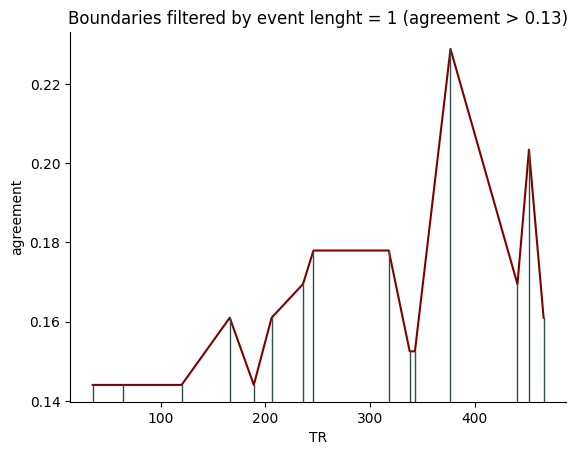

There are 15 events above agreement threshold 0.14. 
After filtered by event length = 1:
               TR  agreement   duration
count   15.000000  15.000000  14.000000
mean   266.466667   0.166102  30.785714
std    138.271403   0.023927  21.159390
min     35.000000   0.144068   5.000000
25%    177.500000   0.148305  14.750000
50%    246.000000   0.161017  26.000000
75%    360.000000   0.173729  43.000000
max    466.000000   0.228814  72.000000


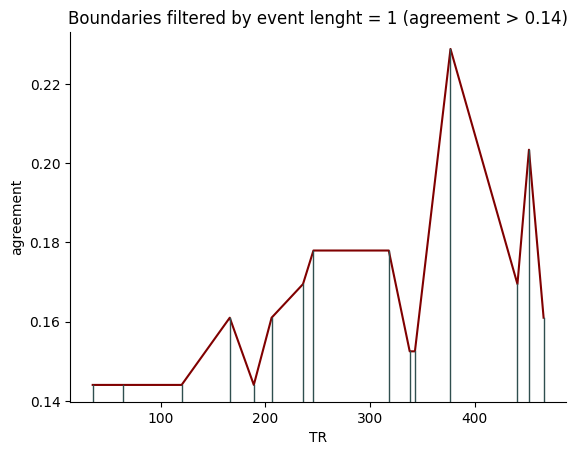

There are 11 events above agreement threshold 0.15. 
After filtered by event length = 1:
               TR  agreement   duration
count   11.000000  11.000000  10.000000
mean   326.272727   0.174114  30.000000
std    103.101010   0.023166  23.041026
min    166.000000   0.152542   5.000000
25%    241.000000   0.161017  11.750000
50%    338.000000   0.169492  25.000000
75%    409.000000   0.177966  38.500000
max    466.000000   0.228814  72.000000


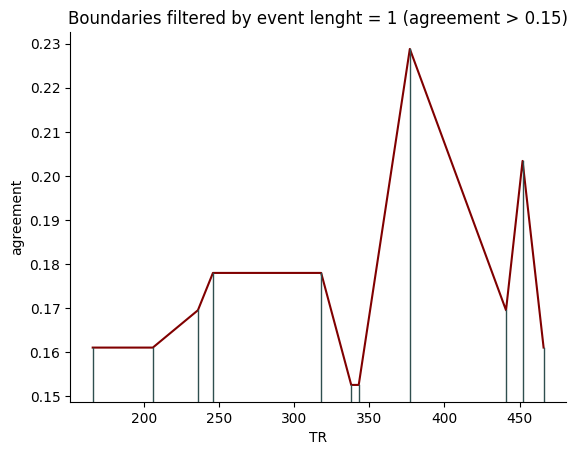

In [80]:
eth=1
filter_by_eth(agree_TR_df, eth)

### Event threshold = 2

There are 44 events above agreement threshold 0.1. 
After filtered by event length = 2:
               TR  agreement   duration
count   27.000000  27.000000  26.000000
mean   254.740741   0.141243  16.807692
std    135.492433   0.033898  12.477241
min     29.000000   0.101695   3.000000
25%    154.500000   0.110169  10.250000
50%    276.000000   0.144068  13.500000
75%    349.000000   0.161017  21.000000
max    466.000000   0.228814  54.000000


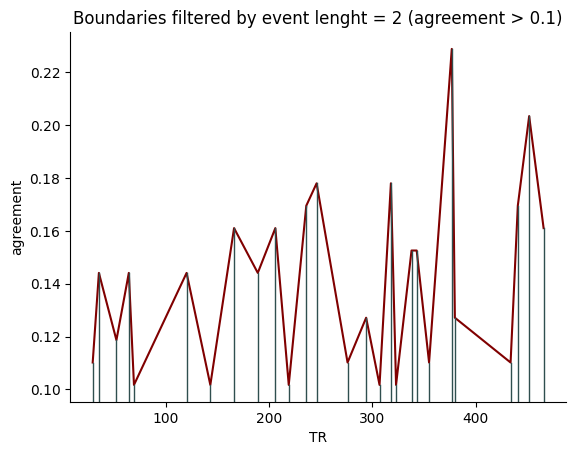

There are 32 events above agreement threshold 0.11. 
After filtered by event length = 2:
               TR  agreement   duration
count   22.000000  22.000000  21.000000
mean   264.409091   0.150231  20.809524
std    141.354556   0.031075  15.148000
min     29.000000   0.110169   3.000000
25%    171.750000   0.127119  11.000000
50%    285.000000   0.148305  17.000000
75%    371.500000   0.167373  24.000000
max    466.000000   0.228814  56.000000


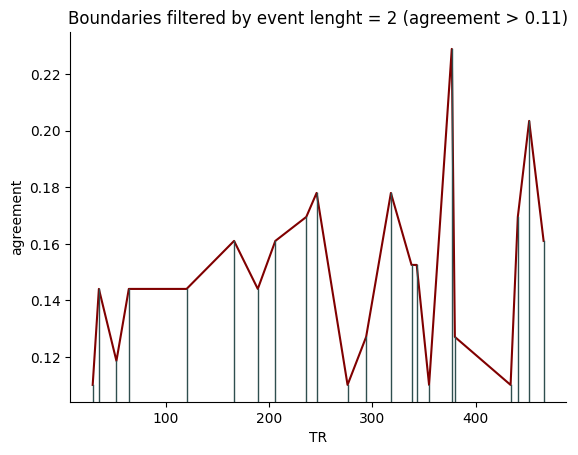

There are 20 events above agreement threshold 0.12. 
After filtered by event length = 2:
               TR  agreement  duration
count   17.000000  17.000000  16.00000
mean   274.764706   0.161515  26.93750
std    132.321356   0.025856  17.90519
min     35.000000   0.127119   3.00000
25%    189.000000   0.144068  13.25000
50%    294.000000   0.161017  23.50000
75%    377.000000   0.169492  37.00000
max    466.000000   0.228814  61.00000


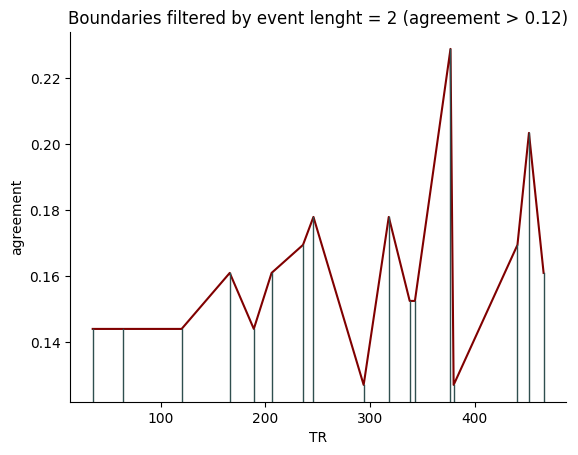

There are 17 events above agreement threshold 0.13. 
After filtered by event length = 2:
               TR  agreement   duration
count   15.000000  15.000000  14.000000
mean   266.466667   0.166102  30.785714
std    138.271403   0.023927  21.159390
min     35.000000   0.144068   5.000000
25%    177.500000   0.148305  14.750000
50%    246.000000   0.161017  26.000000
75%    360.000000   0.173729  43.000000
max    466.000000   0.228814  72.000000


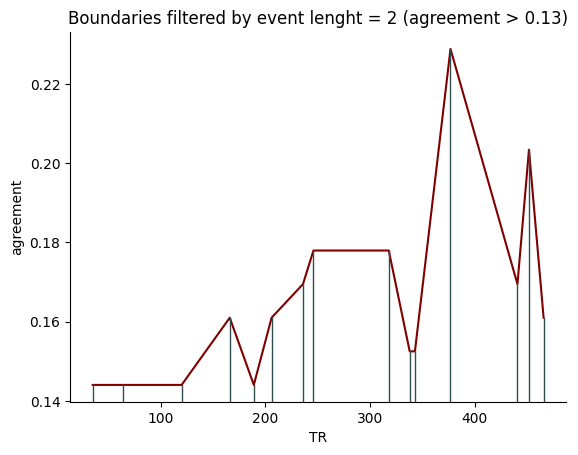

There are 15 events above agreement threshold 0.14. 
After filtered by event length = 2:
               TR  agreement   duration
count   15.000000  15.000000  14.000000
mean   266.466667   0.166102  30.785714
std    138.271403   0.023927  21.159390
min     35.000000   0.144068   5.000000
25%    177.500000   0.148305  14.750000
50%    246.000000   0.161017  26.000000
75%    360.000000   0.173729  43.000000
max    466.000000   0.228814  72.000000


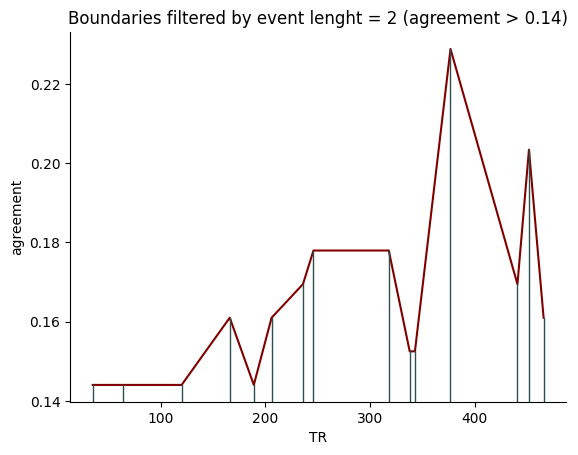

There are 11 events above agreement threshold 0.15. 
After filtered by event length = 2:
               TR  agreement   duration
count   11.000000  11.000000  10.000000
mean   326.272727   0.174114  30.000000
std    103.101010   0.023166  23.041026
min    166.000000   0.152542   5.000000
25%    241.000000   0.161017  11.750000
50%    338.000000   0.169492  25.000000
75%    409.000000   0.177966  38.500000
max    466.000000   0.228814  72.000000


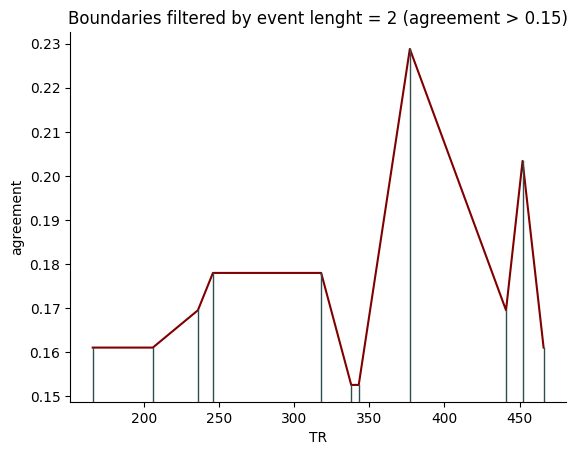

In [81]:
eth=2
filter_by_eth(agree_TR_df, eth)

### Event threshold = 3

There are 44 events above agreement threshold 0.1. 
After filtered by event length = 3:
               TR  agreement   duration
count   27.000000  27.000000  26.000000
mean   254.740741   0.141243  16.807692
std    135.492433   0.033898  12.477241
min     29.000000   0.101695   3.000000
25%    154.500000   0.110169  10.250000
50%    276.000000   0.144068  13.500000
75%    349.000000   0.161017  21.000000
max    466.000000   0.228814  54.000000


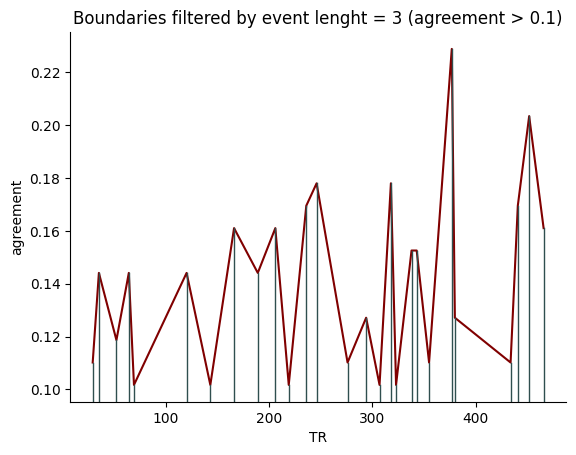

There are 32 events above agreement threshold 0.11. 
After filtered by event length = 3:
               TR  agreement   duration
count   21.000000  21.000000  20.000000
mean   258.904762   0.151332  21.850000
std    142.408885   0.031400  15.318633
min     29.000000   0.110169   5.000000
25%    166.000000   0.127119  11.750000
50%    276.000000   0.152542  17.500000
75%    355.000000   0.169492  25.500000
max    466.000000   0.228814  57.000000


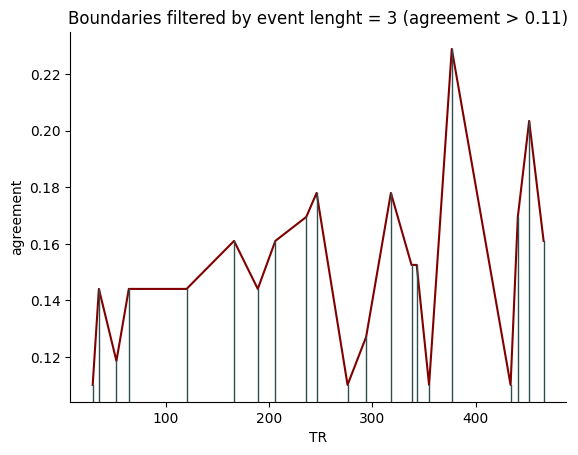

There are 20 events above agreement threshold 0.12. 
After filtered by event length = 3:
               TR  agreement   duration
count   16.000000  16.000000  15.000000
mean   268.187500   0.163665  28.733333
std    133.760093   0.025086  17.729985
min     35.000000   0.127119   5.000000
25%    183.250000   0.144068  15.500000
50%    270.000000   0.161017  24.000000
75%    351.500000   0.171610  40.000000
max    466.000000   0.228814  64.000000


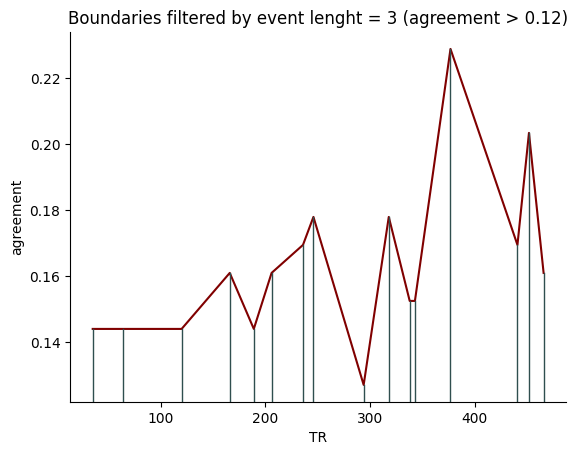

There are 17 events above agreement threshold 0.13. 
After filtered by event length = 3:
               TR  agreement   duration
count   15.000000  15.000000  14.000000
mean   266.466667   0.166102  30.785714
std    138.271403   0.023927  21.159390
min     35.000000   0.144068   5.000000
25%    177.500000   0.148305  14.750000
50%    246.000000   0.161017  26.000000
75%    360.000000   0.173729  43.000000
max    466.000000   0.228814  72.000000


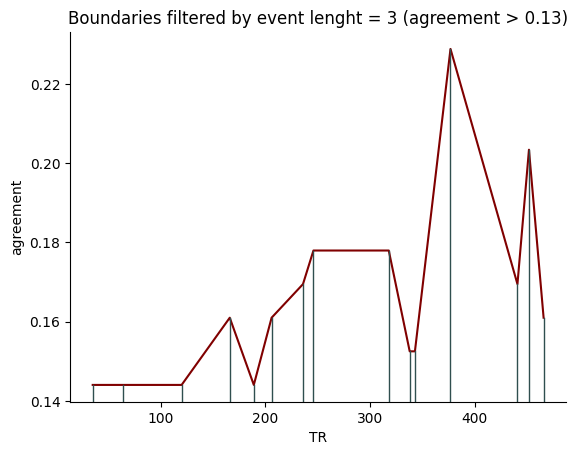

There are 15 events above agreement threshold 0.14. 
After filtered by event length = 3:
               TR  agreement   duration
count   15.000000  15.000000  14.000000
mean   266.466667   0.166102  30.785714
std    138.271403   0.023927  21.159390
min     35.000000   0.144068   5.000000
25%    177.500000   0.148305  14.750000
50%    246.000000   0.161017  26.000000
75%    360.000000   0.173729  43.000000
max    466.000000   0.228814  72.000000


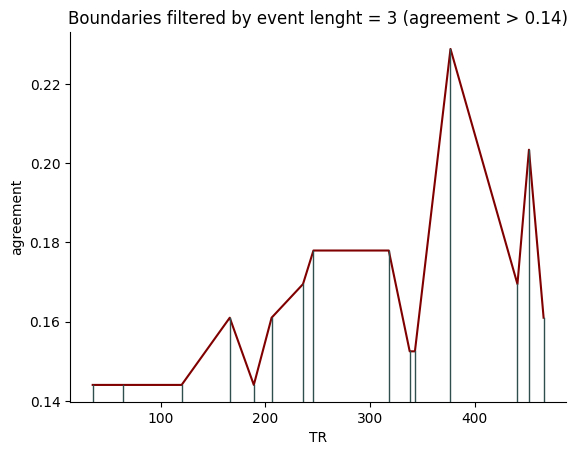

There are 11 events above agreement threshold 0.15. 
After filtered by event length = 3:
               TR  agreement   duration
count   11.000000  11.000000  10.000000
mean   326.272727   0.174114  30.000000
std    103.101010   0.023166  23.041026
min    166.000000   0.152542   5.000000
25%    241.000000   0.161017  11.750000
50%    338.000000   0.169492  25.000000
75%    409.000000   0.177966  38.500000
max    466.000000   0.228814  72.000000


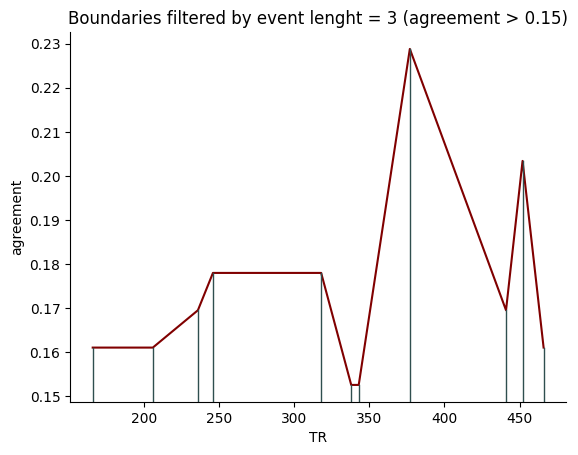

In [82]:
eth=3
filter_by_eth(agree_TR_df, eth)

## Method 2: Rolling average on agreement
Simple rolling window averaging: for each TR, average the agreement value with the agreement values at the the neighboring two TRs (bonus: smooth in seconds rather than TRs, then bin)

### Method 2.1 (TR)

In [83]:
rolling_TR_df = agree_TR_df.copy(deep=True)
rolling_TR_df["rolling_agm"] = rolling_TR_df["agreement"].rolling(3, center=True).mean()
rolling_TR_df.describe()

TR       count   agreement  rolling_agm
count  409.000000  409.000000  409.000000   407.000000
mean   243.051345    5.161369    0.043740     0.043581
std    128.380332    4.488370    0.038037     0.025005
min     15.000000    1.000000    0.008475     0.008475
25%    133.000000    2.000000    0.016949     0.025424
50%    245.000000    4.000000    0.033898     0.036723
75%    352.000000    7.000000    0.059322     0.055085
max    466.000000   27.000000    0.228814     0.135593

In [84]:
for th in np.arange(0.1, 0.23, 0.01):
    n_event1 = rolling_TR_df[rolling_TR_df['agreement'] > th].shape[0]
    n_event2 = rolling_TR_df[rolling_TR_df['rolling_agm'] > th].shape[0]
    print(f"There are {n_event1} events before rolling and {n_event2} events after rolling (agreement > {th})")

There are 44 events before rolling and 18 events after rolling (agreement > 0.1)
There are 32 events before rolling and 10 events after rolling (agreement > 0.11)
There are 20 events before rolling and 6 events after rolling (agreement > 0.12)
There are 17 events before rolling and 2 events after rolling (agreement > 0.13)
There are 15 events before rolling and 0 events after rolling (agreement > 0.13999999999999999)
There are 11 events before rolling and 0 events after rolling (agreement > 0.14999999999999997)
There are 9 events before rolling and 0 events after rolling (agreement > 0.15999999999999998)
There are 4 events before rolling and 0 events after rolling (agreement > 0.16999999999999998)
There are 2 events before rolling and 0 events after rolling (agreement > 0.17999999999999997)
There are 2 events before rolling and 0 events after rolling (agreement > 0.18999999999999995)
There are 2 events before rolling and 0 events after rolling (agreement > 0.19999999999999996)
There ar

### Method 2.2 (second)

In [85]:
agree_second_df = get_agreement('event_seg', 'second', merged_df)
agree_second_df.describe()

second        count    agreement
count  2121.000000  2121.000000  2121.000000
mean    380.545645     1.003772     0.008507
std     192.870694     0.061314     0.000520
min      21.605000     1.000000     0.008475
25%     213.797000     1.000000     0.008475
50%     394.438000     1.000000     0.008475
75%     540.412000     1.000000     0.008475
max     698.903000     2.000000     0.016949

In [86]:
rolling_sec_df = agree_second_df.copy(deep=True)
rolling_sec_df["rolling_agm"] = rolling_sec_df["agreement"].rolling(3, center=True).mean()
# fill the first and last row with "agreement" value
rolling_sec_df["rolling_agm"].iloc[0] = rolling_sec_df["agreement"].iloc[0]
rolling_sec_df["rolling_agm"].iloc[-1] = rolling_sec_df["agreement"].iloc[-1]
print(rolling_sec_df.describe())


            second        count    agreement  rolling_agm
count  2121.000000  2121.000000  2121.000000  2121.000000
mean    380.545645     1.003772     0.008507     0.008507
std     192.870694     0.061314     0.000520     0.000299
min      21.605000     1.000000     0.008475     0.008475
25%     213.797000     1.000000     0.008475     0.008475
50%     394.438000     1.000000     0.008475     0.008475
75%     540.412000     1.000000     0.008475     0.008475
max     698.903000     2.000000     0.016949     0.011299


In [87]:
rolling_sec_df["TR"] = rolling_sec_df["second"].apply(lambda x: np.ceil(x / 1.5))
rolling_sec2TR_df = pd.DataFrame(columns=["TR", "agreement"])
rolling_sec2TR_df["TR"] = rolling_sec_df["TR"].unique()
for i, row in enumerate(rolling_sec2TR_df["TR"]):
    rolling_sec2TR_df.at[i, "agreement"] = rolling_sec_df[rolling_sec_df["TR"] == row]["rolling_agm"].sum()
rolling_sec2TR_df["agreement"] = rolling_sec2TR_df["agreement"].astype(float)

rolling_sec2TR_df.describe()

TR   agreement
count  409.000000  409.000000
mean   243.051345    0.044113
std    128.380332    0.038231
min     15.000000    0.008475
25%    133.000000    0.016949
50%    245.000000    0.033898
75%    352.000000    0.059322
max    466.000000    0.228814

In [88]:
for th in np.arange(0.1, 0.23, 0.01):
    n_event1 = rolling_sec2TR_df[rolling_sec2TR_df['agreement'] > th].shape[0]
    # n_event2 = rolling_TR_df[rolling_TR_df['rolling_agm'] > th].shape[0]
    print(f"There are {n_event1} events after rolling in secondes then converting to TR (agreement > {th})")

There are 44 events after rolling in secondes then converting to TR (agreement > 0.1)
There are 32 events after rolling in secondes then converting to TR (agreement > 0.11)
There are 20 events after rolling in secondes then converting to TR (agreement > 0.12)
There are 18 events after rolling in secondes then converting to TR (agreement > 0.13)
There are 15 events after rolling in secondes then converting to TR (agreement > 0.13999999999999999)
There are 11 events after rolling in secondes then converting to TR (agreement > 0.14999999999999997)
There are 9 events after rolling in secondes then converting to TR (agreement > 0.15999999999999998)
There are 4 events after rolling in secondes then converting to TR (agreement > 0.16999999999999998)
There are 3 events after rolling in secondes then converting to TR (agreement > 0.17999999999999997)
There are 2 events after rolling in secondes then converting to TR (agreement > 0.18999999999999995)
There are 2 events after rolling in secondes 

## Method 3: Detecting peaks using SciPy

In [89]:
def get_tsdf(df, unit):
    df2 = pd.DataFrame(columns=[unit, "agreement"])
    min_val = df[unit].min()
    max_val = df[unit].max()+1
    df2[unit] = np.arange(min_val, max_val, 1)
    for i, row in enumerate(df2[unit]):
        if row in df[unit].values:
            df2.at[i, "agreement"] = df[df[unit] == row]["agreement"].values[0]
        else:
            df2.at[i, "agreement"] = 0
    # convert to float
    df2["agreement"] = df2["agreement"].astype(float)
    return df2

In [124]:
def plot_peaks(df, unit, all_peaks, prominent_peaks, prominence):
    # check if unit is TR or second if not return error
    if unit != "TR" and unit != "second":
        print("Please enter a valid unit: TR or second")
        return
    plt.figure(figsize=(15, 6))
    plt.plot(df[unit], df['agreement'], label="Agreement")
    plt.plot(df[unit].iloc[all_peaks], df['agreement'].iloc[all_peaks], "x", label="All Peaks")
    plt.plot(df[unit].iloc[prominent_peaks], df['agreement'].iloc[prominent_peaks], "o", label=f"Prominent Peaks ({prominence})")
    plt.legend()
    plt.title("Peaks in Agreement")
    plt.xlabel(f"Time ({unit})")
    plt.ylabel("Agreement")
    plt.show()

In [91]:
# fill agree_TR_df with rows so that each TR has a value
agree_TR_df2 = get_tsdf(agree_TR_df, "TR")
agree_TR_df2.describe()

TR   agreement
count  452.000000  452.000000
mean   240.500000    0.039579
std    130.625419    0.038392
min     15.000000    0.000000
25%    127.750000    0.008475
50%    240.500000    0.025424
75%    353.250000    0.050847
max    466.000000    0.228814

There are 124 peaks in agreement
There are 22 prominent (agreement = 0.1) peaks in agreement


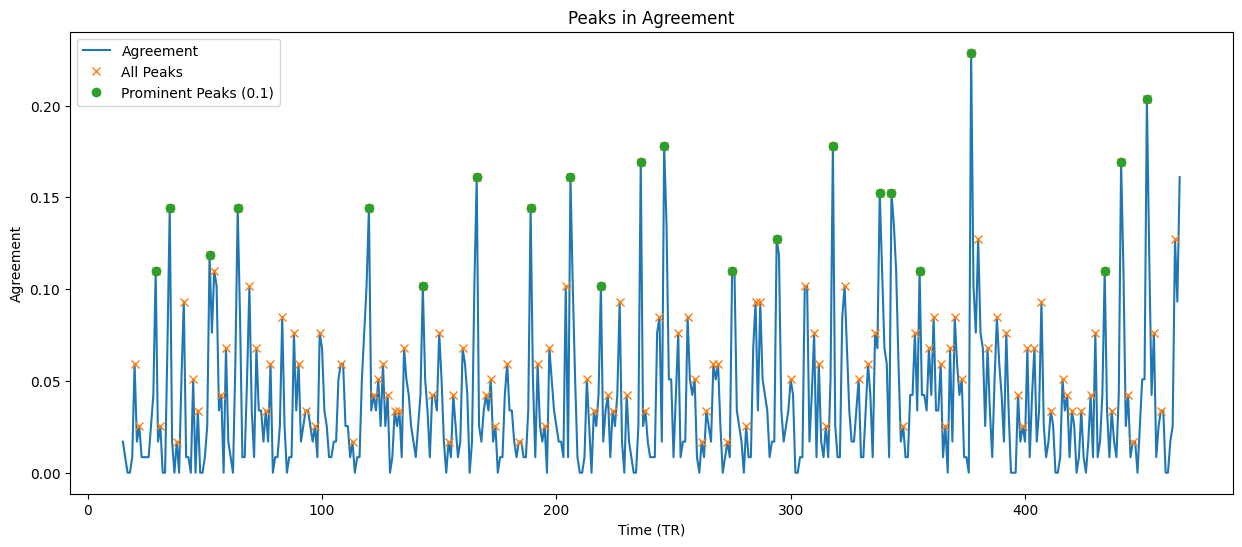

There are 18 prominent (agreement = 0.11) peaks in agreement


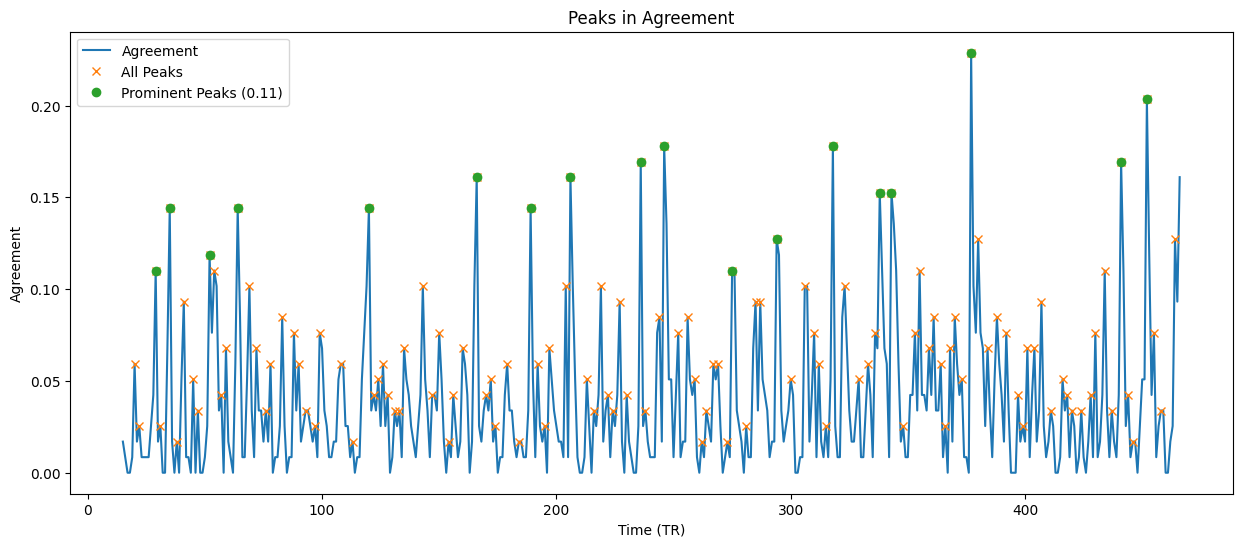

There are 15 prominent (agreement = 0.12) peaks in agreement


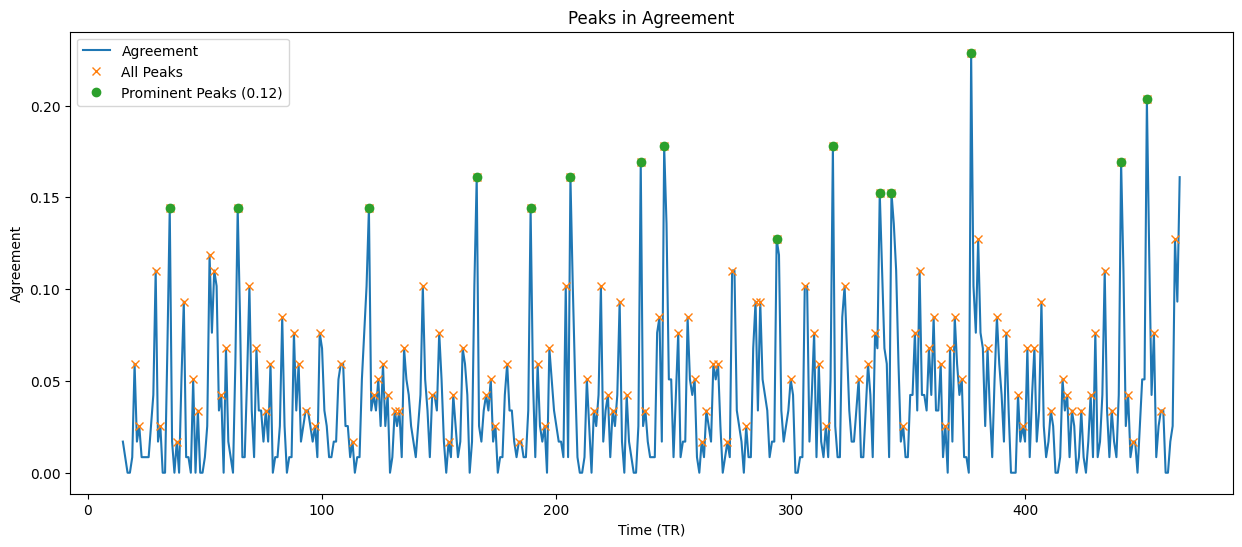

There are 14 prominent (agreement = 0.13) peaks in agreement


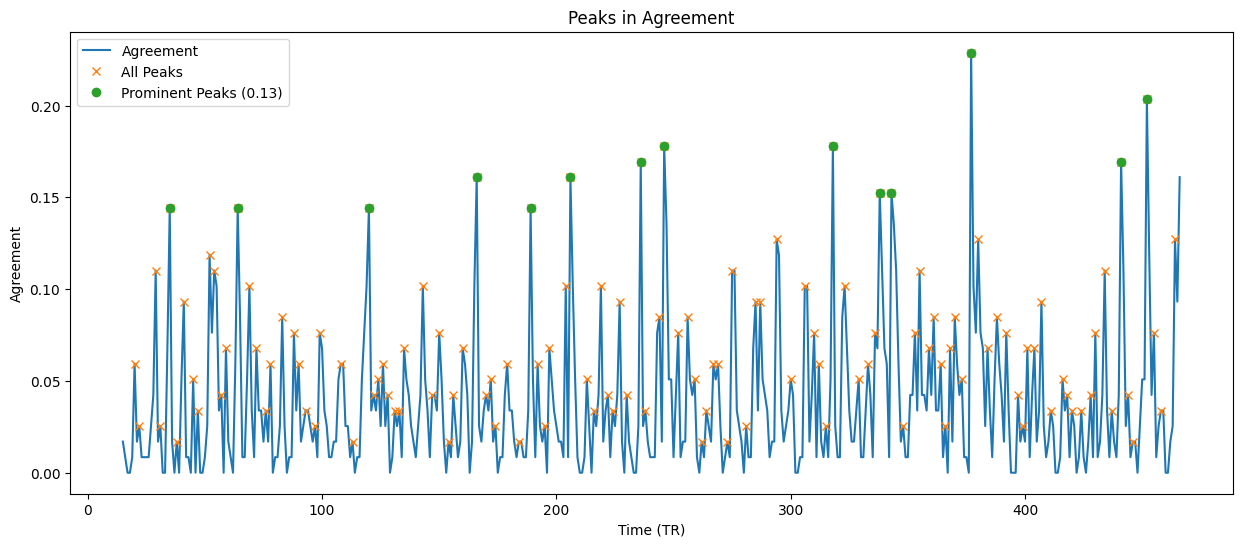

There are 14 prominent (agreement = 0.14) peaks in agreement


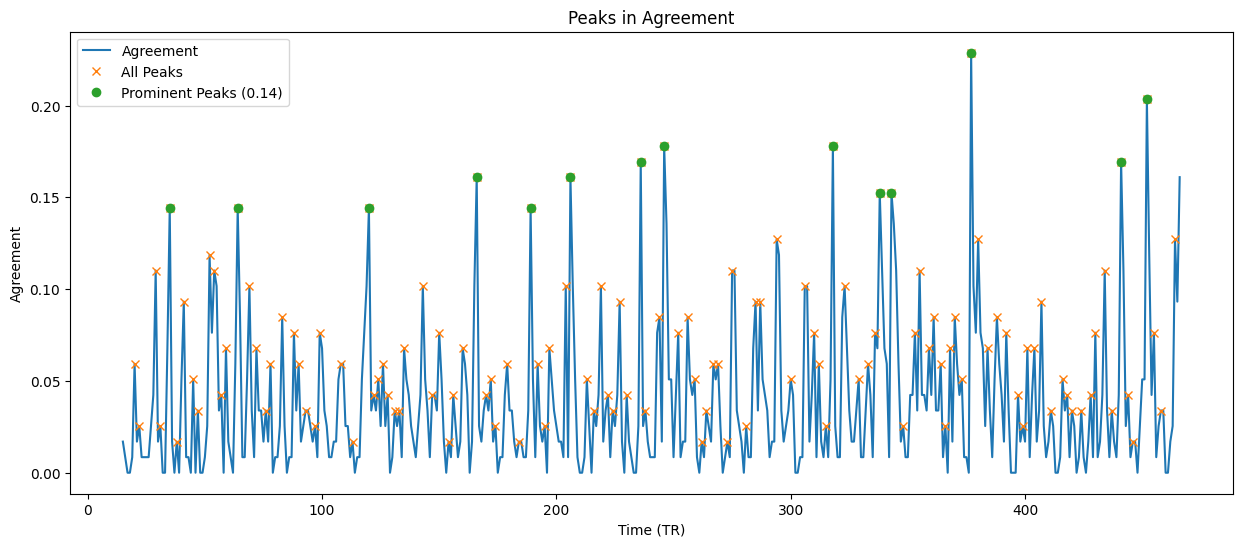

There are 8 prominent (agreement = 0.15) peaks in agreement


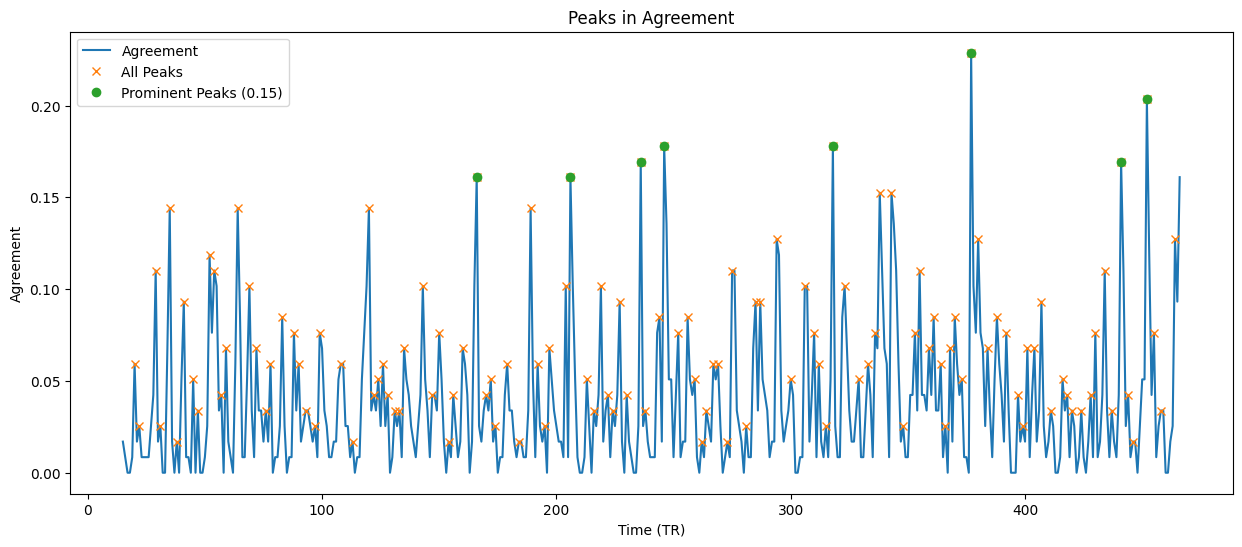

In [126]:
all_peaks, _ = find_peaks(agree_TR_df2['agreement'])
print(f"There are {len(all_peaks)} peaks in agreement")
for prom in [0.1, 0.11, 0.12, 0.13, 0.14, 0.15]:
    prominent_peaks, _ = find_peaks(agree_TR_df2['agreement'], prominence=prom)
    print(f"There are {len(prominent_peaks)} prominent (agreement = {prom}) peaks in agreement")
    plot_peaks(agree_TR_df2, "TR", all_peaks, prominent_peaks, prom)

## Method 4: Aligning reponses with pauses in speech

In [141]:
word_df = pd.read_csv(os.path.join(stimuli_dir, "word_by_onset.csv"), encoding='ISO-8859-1')
# find rows where "text" ends with any punctuation, set "pause" as 1
word_df = word_df.astype({'onset': 'float64', 'duration': 'float64'})
word_df['pause'] = 0
word_df.loc[word_df['text'].str.endswith(('.', ',', '?', '!')), 'pause'] = 1
word_df['onset_TR'] = np.ceil(word_df['onset'] / 1.5)
word_df

onset    text  duration  onset_TR speaker  pause
0      20.97    When      0.21      14.0     NaN      0
1      21.18     the      0.09      15.0     NaN      0
2      21.27   phone      0.27      15.0     NaN      0
3      21.54    rang      0.42      15.0     NaN      0
4      22.05     the      0.15      15.0     NaN      0
...      ...     ...       ...       ...     ...    ...
1919  695.19     she      0.12     464.0     NaN      0
1920  695.31  pulled      0.24     464.0     NaN      0
1921  695.55    back      0.21     464.0     NaN      0
1922  695.76     her      0.12     464.0     NaN      0
1923  695.88   hand.      0.33     464.0     NaN      1

[1924 rows x 6 columns]

In [150]:
# get onset_TR where pause = 1
pause_TRs = word_df[word_df['pause'] == 1]['onset_TR'].unique()
print(f"There are {len(pause_TRs)} TRs with pause")
# initialize a new dataframe with TRs and duration
pause_df = pd.DataFrame(columns=["TR", "duration"])
pause_df["TR"] = pause_TRs
pause_df["duration"] = pause_df["TR"].diff(-1)
# fill the last row with 465 - TR if TR is < 465
if pause_df["TR"].iloc[-1] < 465:
    pause_df["duration"].iloc[-1] = 465 - pause_df["TR"].iloc[-1]
else:
    pause_df["duration"].iloc[-1] = 0

pause_df["duration"] = abs(pause_df["duration"])

There are 271 TRs with pause


In [143]:
def filter_elements(A, list_B, deltas):
    if len(list_B) != len(deltas):
        raise ValueError("list_B and deltas must have the same length.")
    
    # Find the position where element A would fit in the sorted list
    pos = bisect_left(list_B, A)
    
    # If A is out of bounds of list_B, return None
    if pos == 0 or pos == len(list_B):
        return None
    
    # Identify closest elements to A in list_B
    B = list_B[pos]
    B_prev = list_B[pos - 1]
    
    # Identify next closest elements if they exist
    B_next = list_B[pos + 1] if pos + 1 < len(list_B) else float('inf')
    
    # Filtering conditions
    if A == B:
        return B
    elif B_prev <= A <= min(B_prev + deltas[pos - 1], B):
        return B_prev
    elif B <= A <= min(B + deltas[pos], B_next):
        return B
    else:
        return None 


In [152]:
list_B = pause_df["TR"].values
deltas = pause_df["duration"].values
# filter elements in agree_TR_df2["TR"] using list_B and deltas
agree_TR_df_aligned = agree_TR_df.copy(deep=True)
agree_TR_df_aligned["filtered_TR"] = agree_TR_df_aligned["TR"].apply(lambda x: filter_elements(x, list_B, deltas))

In [153]:
agree_TR_df_aligned2 = pd.DataFrame(columns=["TR", "agreement"])
agree_TR_df_aligned2["TR"] = agree_TR_df_aligned["filtered_TR"].unique()
# drop nan
agree_TR_df_aligned2 = agree_TR_df_aligned2.dropna(subset=["TR"])
for i, row in enumerate(agree_TR_df_aligned2["TR"]):
    agree_TR_df_aligned2.at[i, "agreement"] = agree_TR_df_aligned[agree_TR_df_aligned["filtered_TR"] == row]["agreement"].sum()
# drop nan
agree_TR_df_aligned2 = agree_TR_df_aligned2.dropna()
agree_TR_df_aligned2["agreement"] = agree_TR_df_aligned2["agreement"].astype(float)
# reset index
agree_TR_df_aligned2 = agree_TR_df_aligned2.reset_index(drop=True)
agree_TR_df_aligned2.describe()

TR   agreement
count  255.000000  255.000000
mean   241.321569    0.068794
std    128.266756    0.071223
min     19.000000    0.008475
25%    124.500000    0.025424
50%    239.000000    0.042373
75%    353.500000    0.084746
max    463.000000    0.483051

### Detecting Peaks using SciPy

In [154]:
# fill agree_TR_df with rows so that each TR has a value
agree_TR_df_aligned3 = get_tsdf(agree_TR_df_aligned2, "TR")
agree_TR_df_aligned3.describe()

TR   agreement
count  445.000000  445.000000
mean   241.000000    0.039421
std    128.604691    0.063737
min     19.000000    0.000000
25%    130.000000    0.000000
50%    241.000000    0.016949
75%    352.000000    0.050847
max    463.000000    0.483051

There are 133 peaks in agreement
There are 44 prominent (agreement = 0.1) peaks in agreement


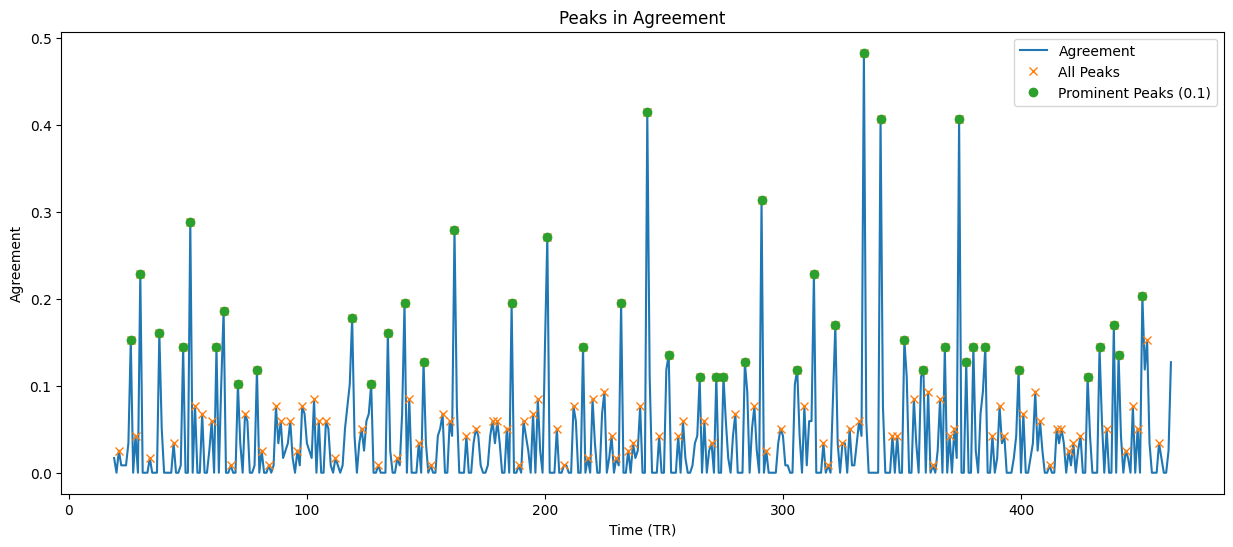

There are 42 prominent (agreement = 0.11) peaks in agreement


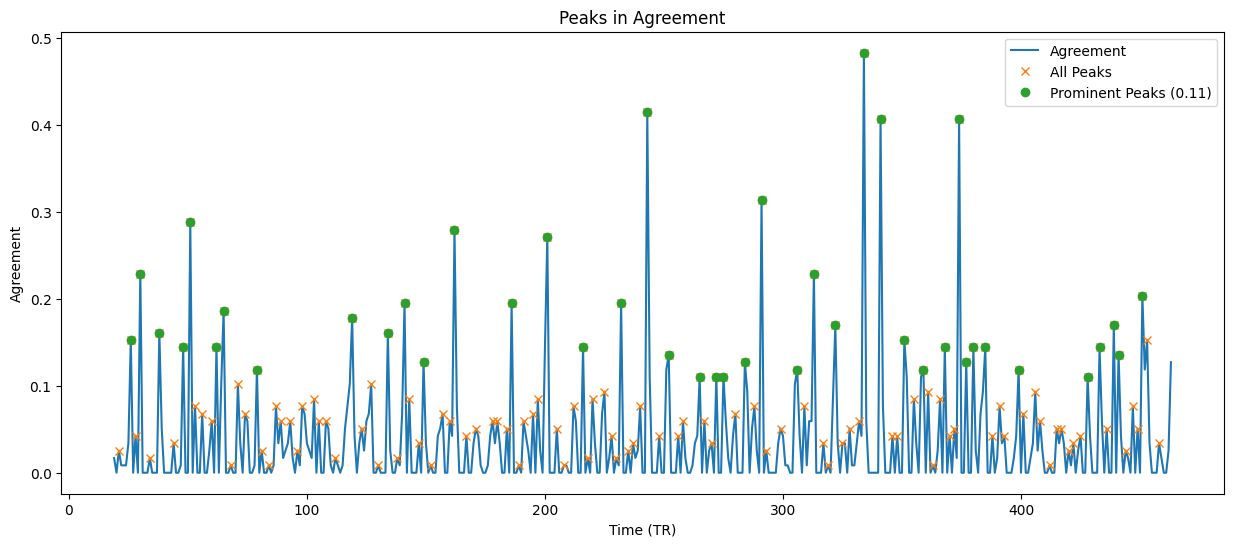

There are 34 prominent (agreement = 0.12) peaks in agreement


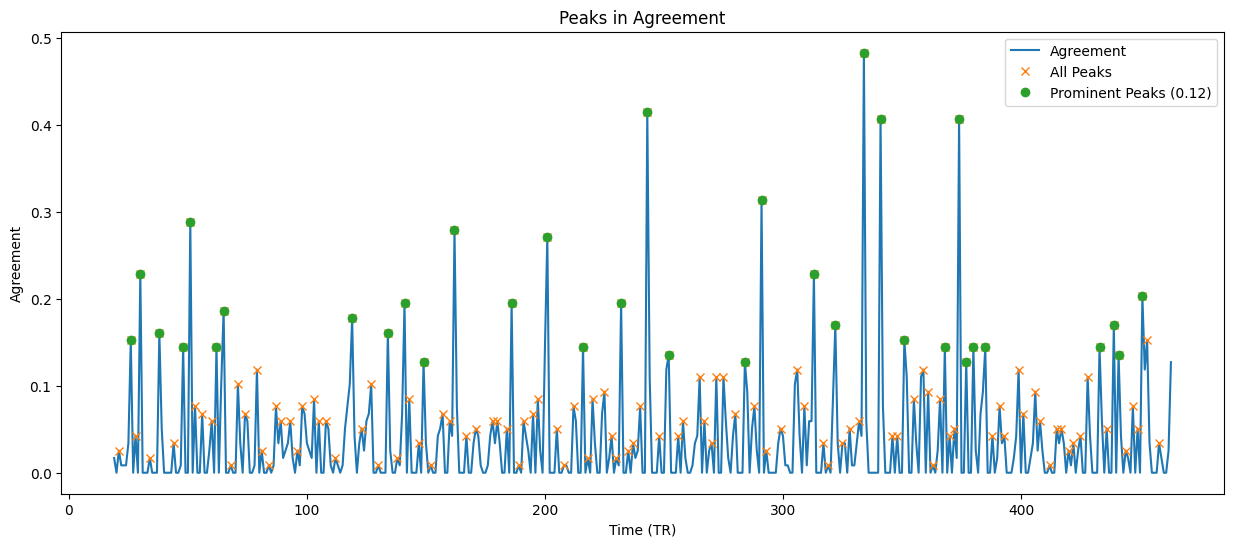

There are 31 prominent (agreement = 0.13) peaks in agreement


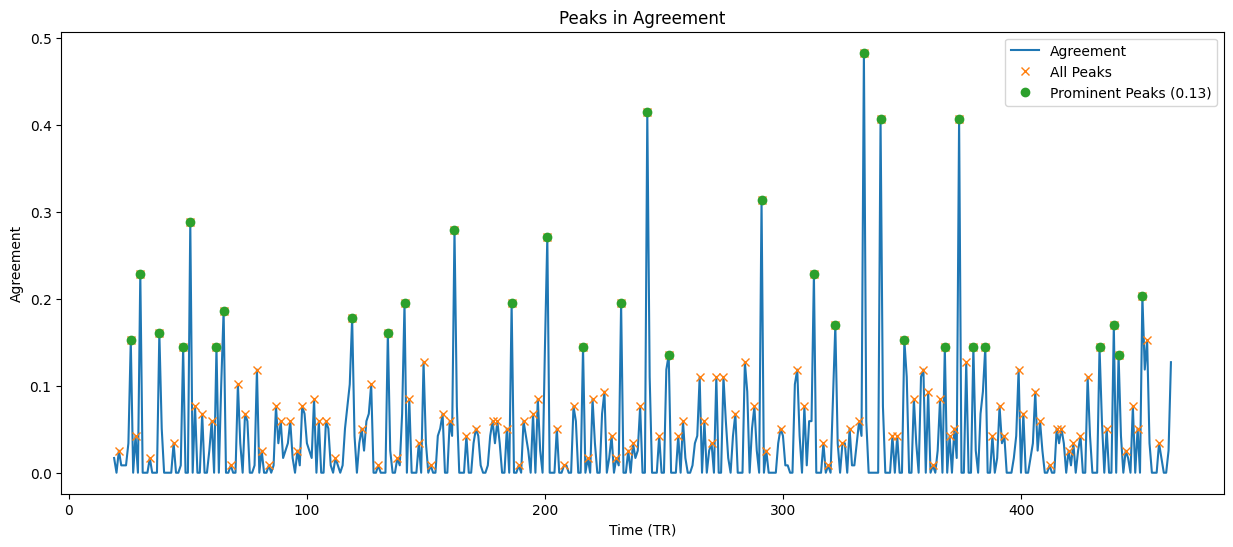

There are 29 prominent (agreement = 0.14) peaks in agreement


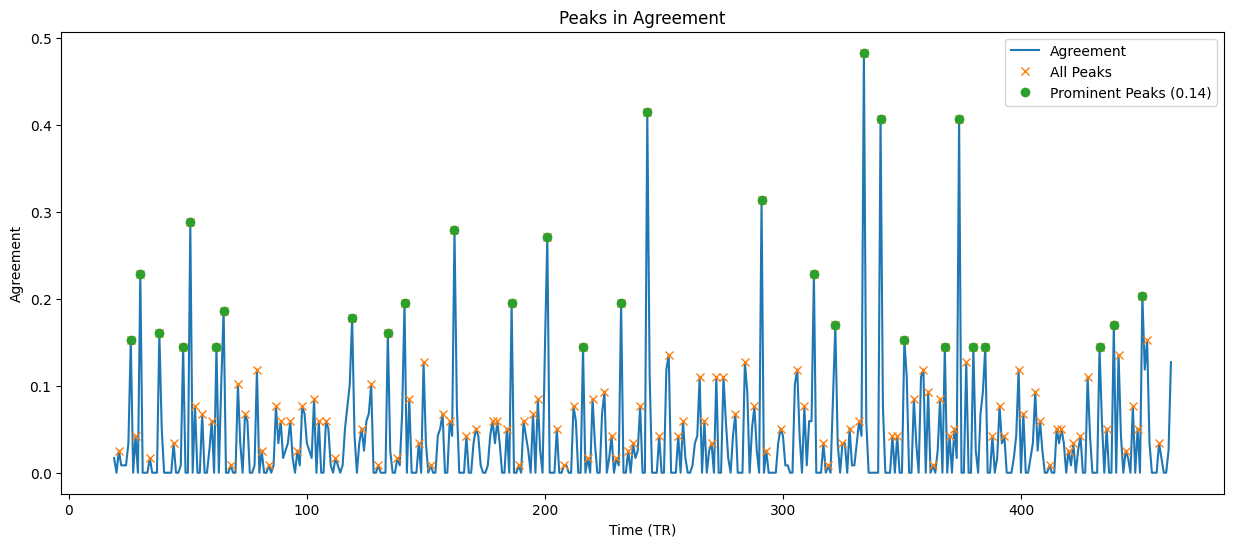

There are 22 prominent (agreement = 0.15) peaks in agreement


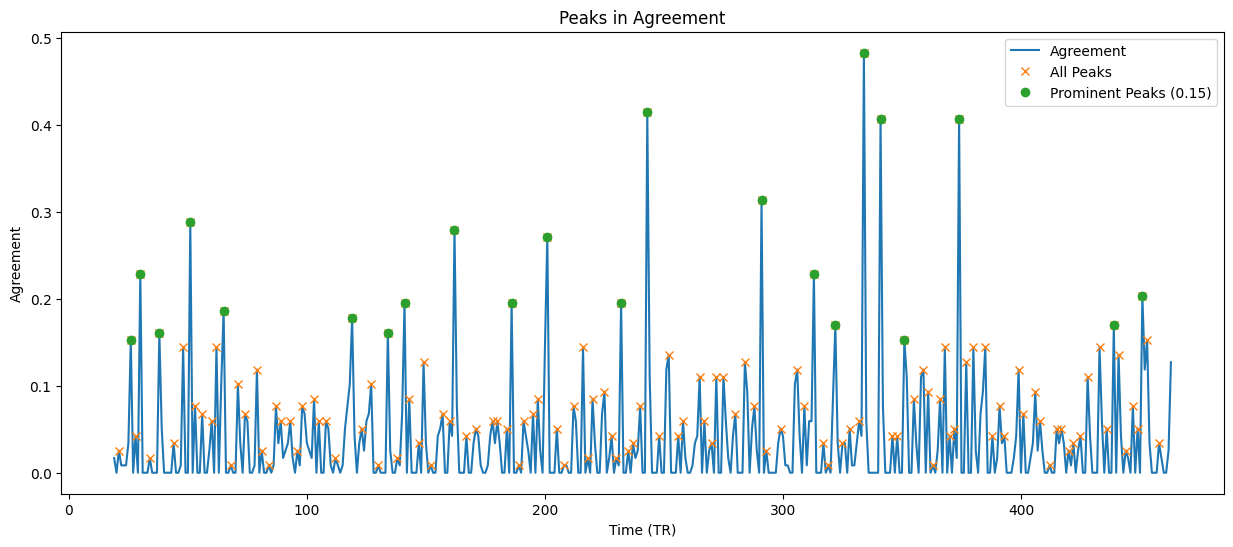

There are 20 prominent (agreement = 0.16) peaks in agreement


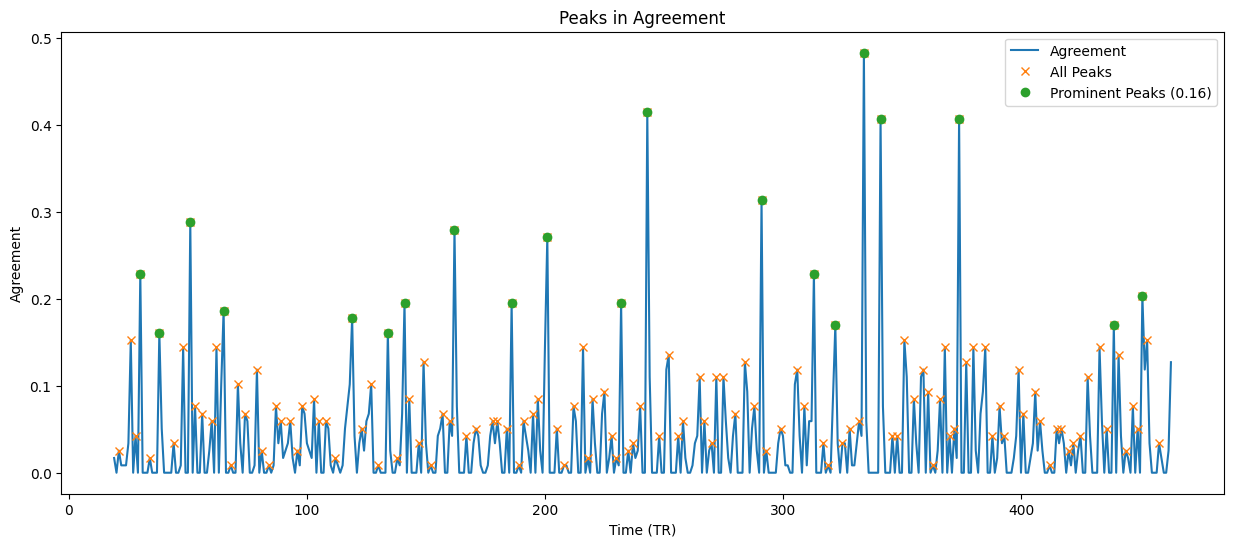

There are 16 prominent (agreement = 0.17) peaks in agreement


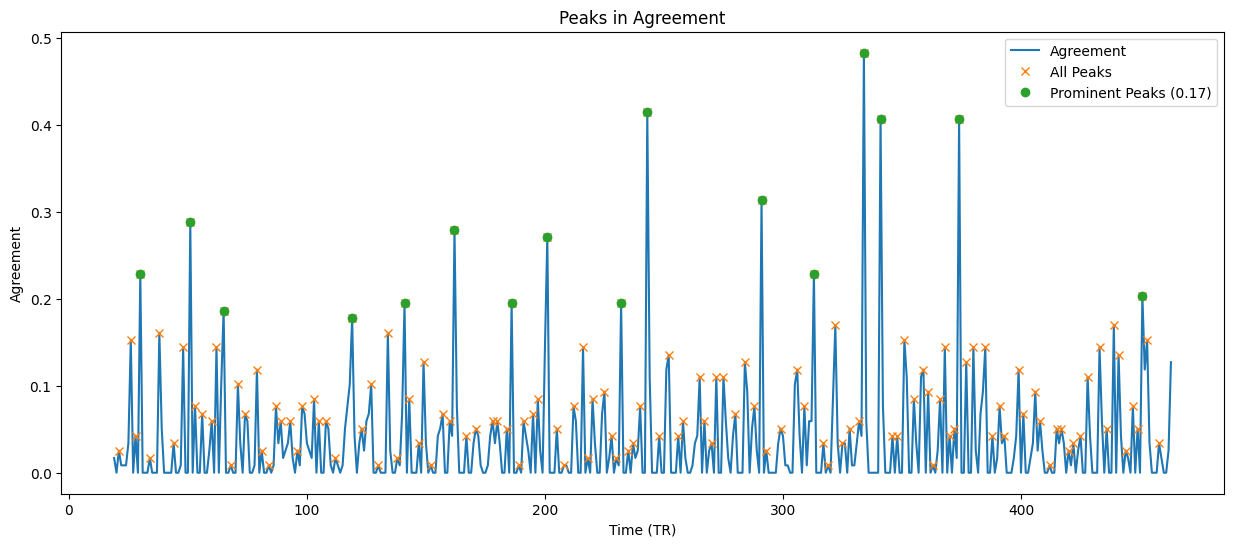

There are 15 prominent (agreement = 0.18) peaks in agreement


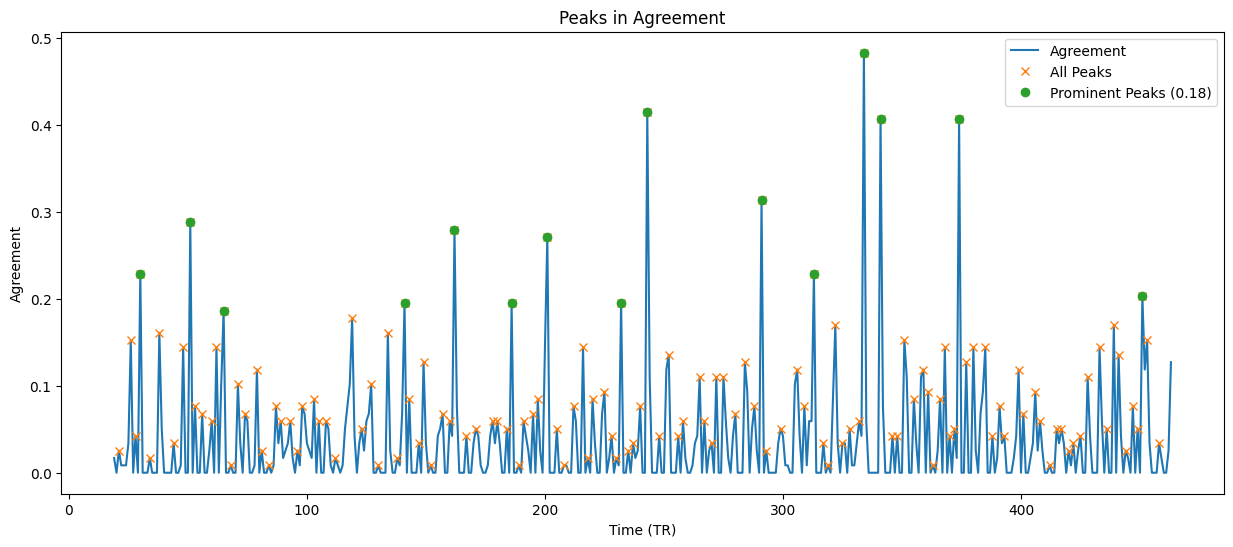

There are 14 prominent (agreement = 0.19) peaks in agreement


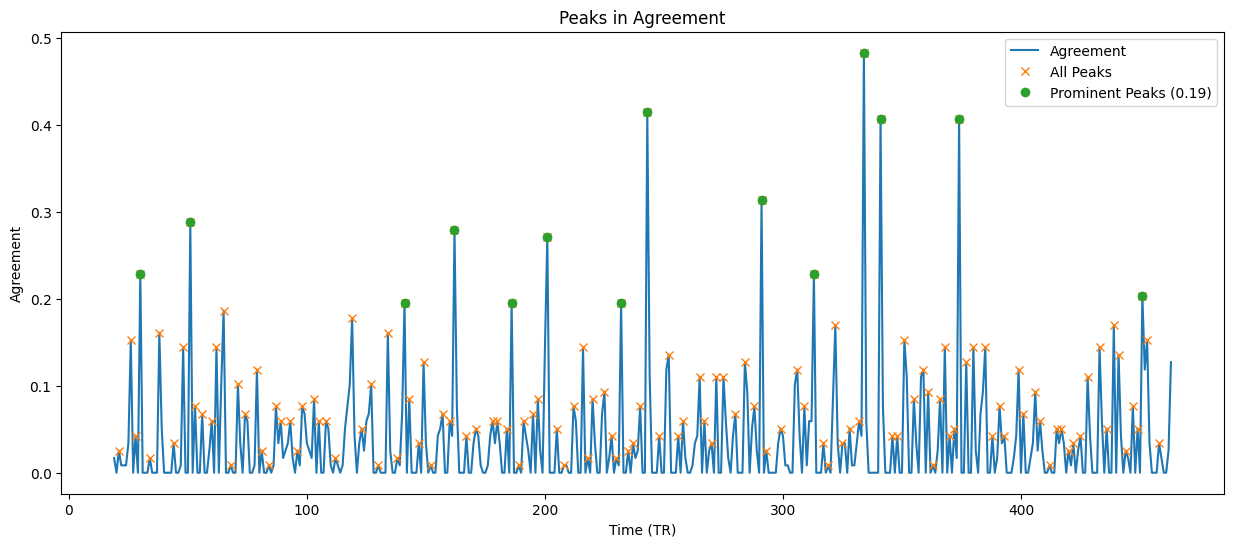

There are 11 prominent (agreement = 0.2) peaks in agreement


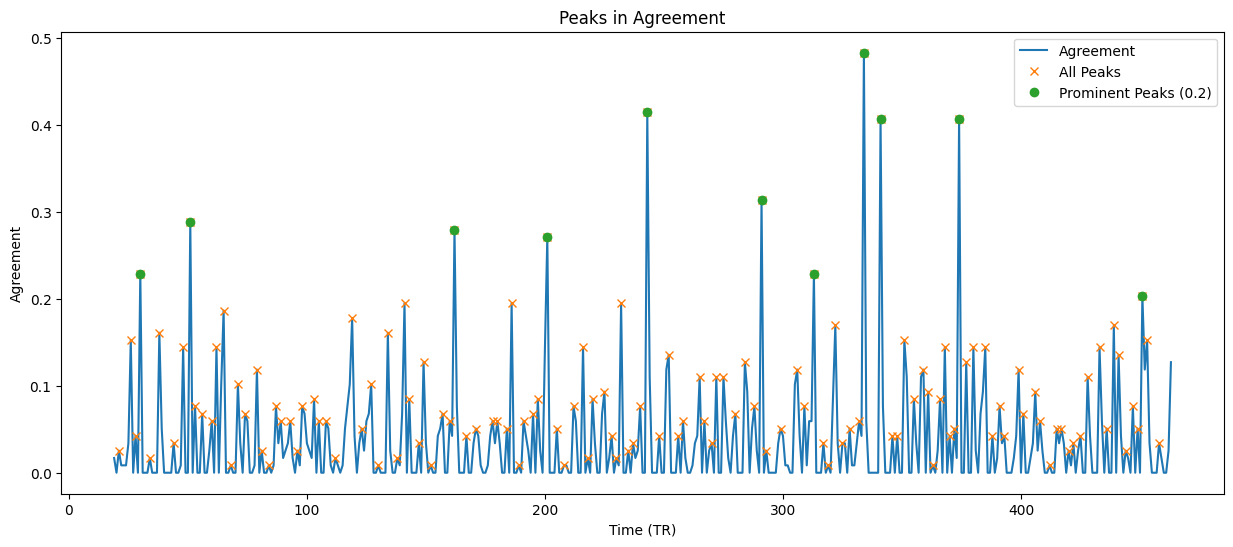

There are 10 prominent (agreement = 0.21) peaks in agreement


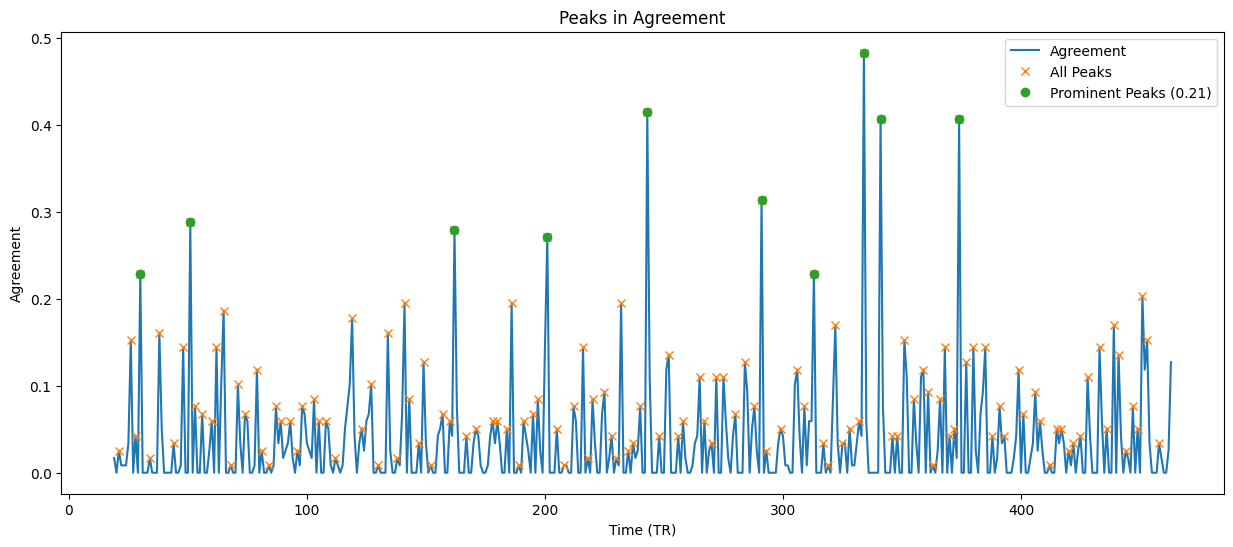

There are 10 prominent (agreement = 0.22) peaks in agreement


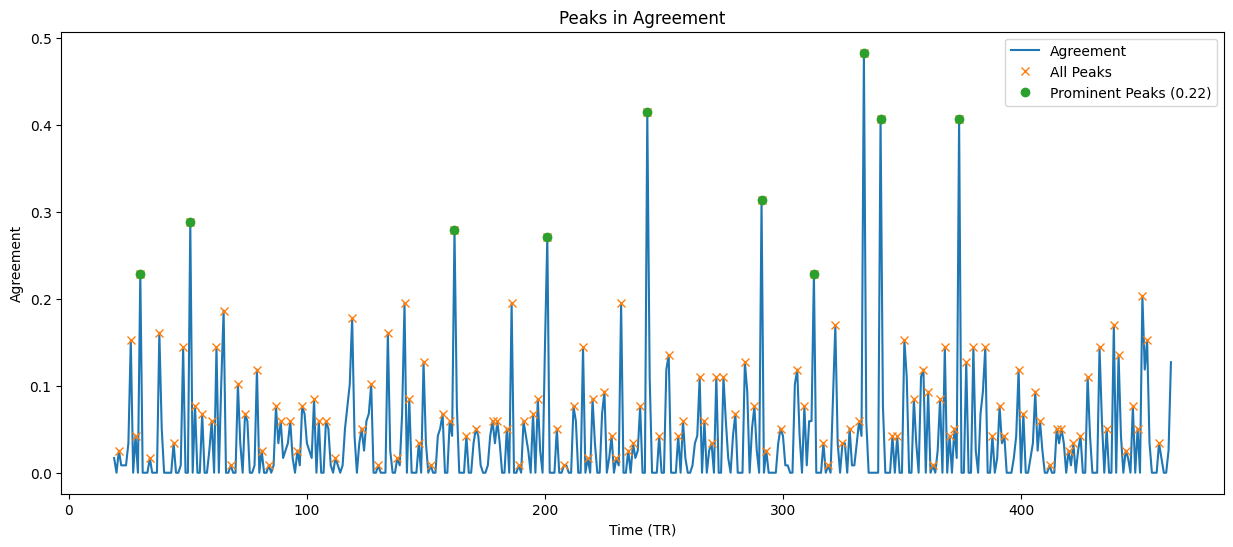

In [156]:
all_peaks, _ = find_peaks(agree_TR_df_aligned3['agreement'])
print(f"There are {len(all_peaks)} peaks in agreement")
for prom in np.arange(0.1, 0.23, 0.01):
    prom = np.round(prom, 2)
    prominent_peaks, _ = find_peaks(agree_TR_df_aligned3['agreement'], prominence=prom)
    print(f"There are {len(prominent_peaks)} prominent (agreement = {prom}) peaks in agreement")
    plot_peaks(agree_TR_df_aligned3, "TR", all_peaks, prominent_peaks, prom)


### Comparing with the non-aligned results

In [158]:
prom_peaks_na0, _ = find_peaks(agree_TR_df2['agreement'], prominence=0.1)
prom_peaks_na1, _ = find_peaks(agree_TR_df2['agreement'], prominence=0.11)
prom_peaks_na2, _ = find_peaks(agree_TR_df2['agreement'], prominence=0.12)
prom_peaks_na3, _ = find_peaks(agree_TR_df2['agreement'], prominence=0.13)
prom_peaks_na4, _ = find_peaks(agree_TR_df2['agreement'], prominence=0.14)
prom_peaks_na5, _ = find_peaks(agree_TR_df2['agreement'], prominence=0.15)

prom_peaks_al0, _ = find_peaks(agree_TR_df_aligned3['agreement'], prominence=0.1)
prom_peaks_al1, _ = find_peaks(agree_TR_df_aligned3['agreement'], prominence=0.11)
prom_peaks_al2, _ = find_peaks(agree_TR_df_aligned3['agreement'], prominence=0.12)
prom_peaks_al3, _ = find_peaks(agree_TR_df_aligned3['agreement'], prominence=0.13)
prom_peaks_al4, _ = find_peaks(agree_TR_df_aligned3['agreement'], prominence=0.14)
prom_peaks_al5, _ = find_peaks(agree_TR_df_aligned3['agreement'], prominence=0.15)

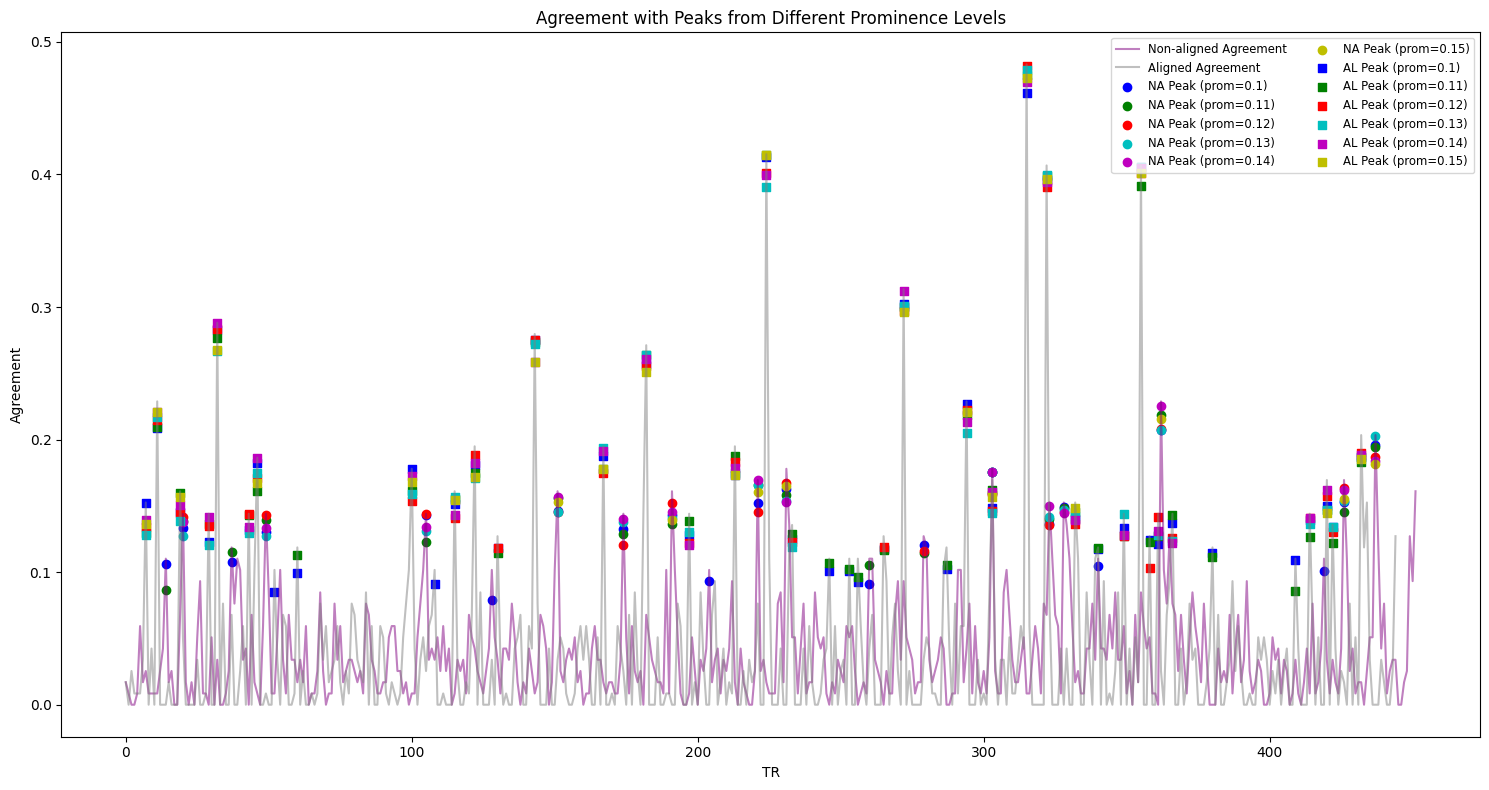

In [166]:
# Create a function to add a small jitter
def add_jitter(arr, magnitude=0.025):  # magnitude controls the amount of jitter
    jitter = (np.random.rand(len(arr)) - 1) * magnitude
    return arr + jitter

# Create a figure and axis
plt.figure(figsize=(15, 8))

# Plot the agreement columns for both dataframes
plt.plot(agree_TR_df2['agreement'], label='Non-aligned Agreement', color='purple', alpha=0.5)
plt.plot(agree_TR_df_aligned3['agreement'], label='Aligned Agreement', color='grey', alpha=0.5)

# Define lists for the peak indices and colors
na_peaks = [prom_peaks_na0, prom_peaks_na1, prom_peaks_na2, prom_peaks_na3, prom_peaks_na4, prom_peaks_na5]
al_peaks = [prom_peaks_al0, prom_peaks_al1, prom_peaks_al2, prom_peaks_al3, prom_peaks_al4, prom_peaks_al5]
colors = ['b', 'g', 'r', 'c', 'm', 'y']  # Colors for each prominence level

# Plot the peaks for non-aligned group using 'o' style with jitter
for peaks, color in zip(na_peaks, colors):
    jittered_agreement = add_jitter(agree_TR_df2['agreement'].iloc[peaks])
    plt.scatter(peaks, jittered_agreement, marker='o', color=color, label=f'NA Peak (prom={np.round(colors.index(color) * 0.01 + 0.1, 2)})')

# Plot the peaks for aligned group using 's' style with jitter
for peaks, color in zip(al_peaks, colors):
    jittered_agreement = add_jitter(agree_TR_df_aligned3['agreement'].iloc[peaks])
    plt.scatter(peaks, jittered_agreement, marker='s', color=color, label=f'AL Peak (prom={np.round(colors.index(color) * 0.01 + 0.1, 2)})')

# Set labels, title, and legend
plt.xlabel('TR')
plt.ylabel('Agreement')
plt.title('Agreement with Peaks from Different Prominence Levels')
plt.legend(loc='upper right', fontsize='small', ncol=2)

# Display the plot
plt.tight_layout()
plt.show()


## Plot for Sam :) 

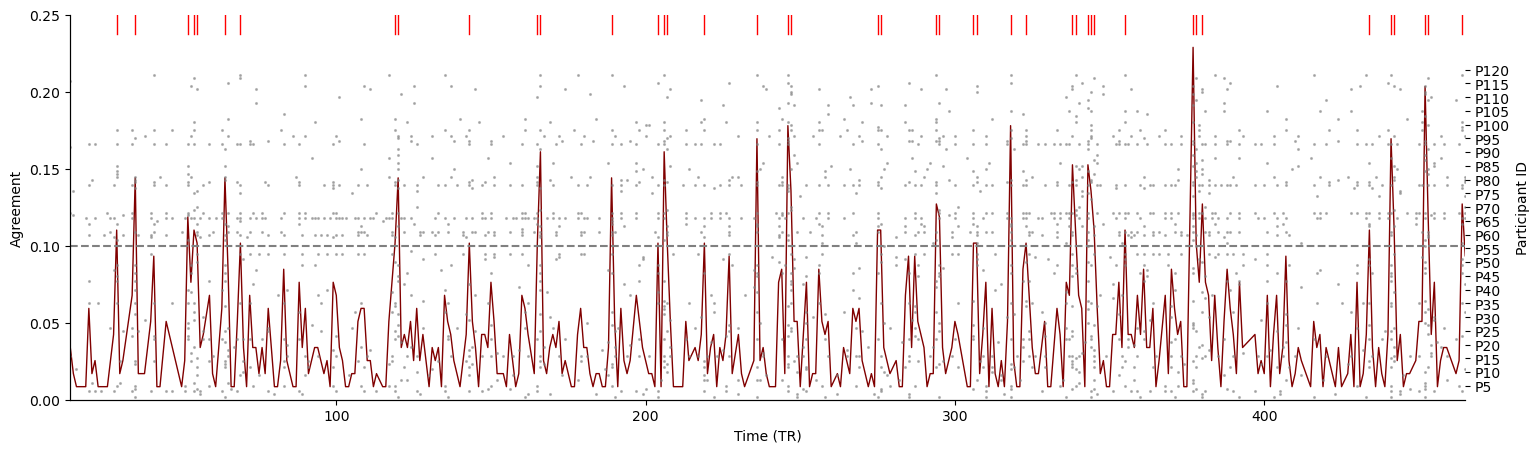

In [42]:
fig, ax1 = plt.subplots(figsize=(18, 5))

# Plot the original agreement line in dark red
ax1.plot(response_df['TR'], response_df['agreement'], color='maroon', linewidth=1)

# Plot a dotted gray hline indicating the consensus cutoff (around .10)
ax1.axhline(y=0.10, color='gray', linestyle='--')

# Trim ylim and xlim for the left y-axis
ax1.set_ylim(0, 0.25)
ax1.set_xlim(14, 465)

# Label axes for the left y-axis
ax1.set_xlabel("Time (TR)")
ax1.set_ylabel("Agreement")

# Place red ticks at the top indicating dots above threshold
threshold_indices = response_df[response_df['agreement'] > 0.10].index
for index in threshold_indices:
    ax1.axvline(x=response_df['TR'].iloc[index], color='red', ymin=0.95, ymax=1, linewidth=1)


# Create a second y-axis to plot the new scatter plot
ax2 = ax1.twinx()

# Scatter plot using the right y-axis
y_value = 1
for i, row in enumerate(merged_df['event_seg_TRs']):
    if row is None or (isinstance(row, float) and np.isnan(row)):
        continue
    ax2.scatter(row, [y_value] * len(row), color='gray', s=1.5, alpha=0.5)
    y_value += 1

# Trim ylim and xlim for the right y-axis
ax2.set_ylim(0, 140)
# reset y ticks by add P to the beginning of the number
# Set y-ticks for ax2 and prepend 'P' to each tick label to indicate participants,
# while filtering out 0 and 140
# Set y-ticks for ax2 with an interval of 5, starting from 5 to 115 (or whatever upper limit you desire)
ax2_yticks = np.arange(5, 121, 5)
ax2.set_yticks(ax2_yticks)
ax2.set_yticklabels(['P{}'.format(int(ytick)) for ytick in ax2_yticks])

# Label for the right y-axis
ax2.set_ylabel("Participant ID")

# Remove the top and right spines
sns.despine()

plt.show()


In [27]:
for th in np.arange(0.1, 0.23, 0.01):
    n_event = response_df[response_df['agreement'] > th].shape[0]
    print(f"There are {n_event} events above agreement threshold {th}")

There are 45 events above agreement threshold 0.1
There are 32 events above agreement threshold 0.11
There are 20 events above agreement threshold 0.12
There are 17 events above agreement threshold 0.13
There are 15 events above agreement threshold 0.13999999999999999
There are 11 events above agreement threshold 0.14999999999999997
There are 9 events above agreement threshold 0.15999999999999998
There are 4 events above agreement threshold 0.16999999999999998
There are 2 events above agreement threshold 0.17999999999999997
There are 2 events above agreement threshold 0.18999999999999995
There are 2 events above agreement threshold 0.19999999999999996
There are 1 events above agreement threshold 0.20999999999999996
There are 1 events above agreement threshold 0.21999999999999995


## Let's do some filteration using the post-survey data

### Q1: Who was the gray-haired man?

In [14]:
merged_df['ch1'].value_counts()

Lee           69
Arthur        33
Don't know    16
Name: ch1, dtype: int64

### Q2: Who was the man looking for his wife?

In [15]:
merged_df['ch2'].value_counts()

Arthur        83
Lee           30
Don't know     5
Name: ch2, dtype: int64

### Q3: Who was the girl sitting next to the gray-haired man?

In [16]:
merged_df['ch3'].value_counts()

Don't know    54
Joanie        35
Mary          29
Name: ch3, dtype: int64

### Find those subjects who got the correct answer to Q1 and Q2

In [17]:
# find the subjects choosing Lee for ch1 and Arthur for ch2
correct_subjs = merged_df[(merged_df['ch1'] == 'Lee') & (merged_df['ch2'] == 'Arthur')]
# correct_subjs = merged_df[merged_df['ch2'] == 'Arthur']
# correct_subjs = merged_df
print(correct_subjs.shape)
# clear the columns engagement and clarity removing the string with () then convert the value to float
correct_subjs['engagement'] = correct_subjs['engagement'].str.replace(r"\(.*\)","").astype(float)
correct_subjs['clarity'] = correct_subjs['clarity'].str.replace(r"\(.*\)","").astype(float)

(69, 13)


In [18]:
correct_subjs['ch3'].value_counts()

Don't know    30
Joanie        22
Mary          17
Name: ch3, dtype: int64

In [19]:
# fig, ax1 = plt.subplots(figsize=(18, 5))

# # Extract the data for the lines
# engagement_line_data = correct_subjs[["participant", "engagement"]]
# clarity_line_data = correct_subjs[["participant", "clarity"]]

# # Extract the data for the scatter plot
# ch3_data = correct_subjs[["participant", "ch3"]]
# ch3_colors = {"Mary": "red", "Don't know": "blue", "Joanie": "green"}

# # Plot the lines directly on ax1
# ax1.plot(engagement_line_data["participant"], engagement_line_data["engagement"], label="Engagement")
# ax1.plot(clarity_line_data["participant"], clarity_line_data["clarity"], label="Clarity")

# # Create the scatter plot on a twin axes
# ax2 = ax1.twinx()
# ax2.scatter(ch3_data["participant"], ch3_data["ch3"], c=ch3_data["ch3"].map(ch3_colors), s=10)

# # Set the y-axis label and tick parameters for the twin axes
# # ax2.set_ylabel("ch3", color="red")
# ax2.tick_params(axis="y")

# # Set the labels and title
# ax1.set_xlabel("Participant ID")
# ax1.set_ylabel("Score")
# # plt.title("Engagement and Clarity Scores by Participant ID")

# # Add the legend a little bit higher on the plot
# ax1.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=3)

# # Rotate the x-ticks for ax1
# for tick in ax1.get_xticklabels():
#     tick.set_rotation(90)


# # Show the plot
# plt.show()


## Let's look at the filtered event segmentation data

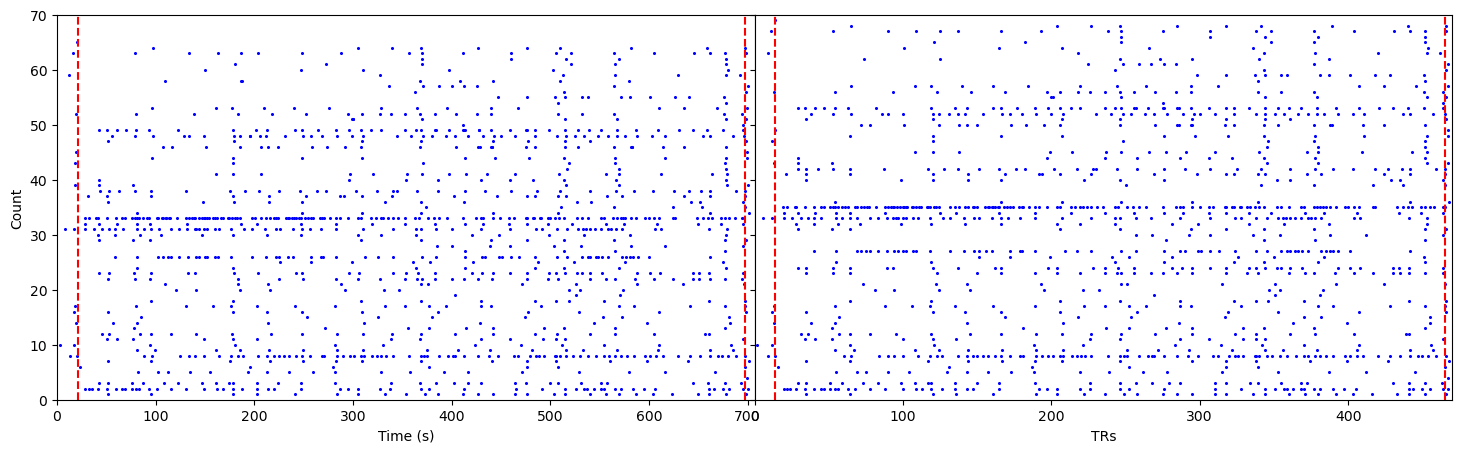

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5), sharey=True)

# Remove the space between the subplots
plt.subplots_adjust(wspace=0)

# Plot 1
y_value = 1
for i, row in enumerate(correct_subjs['event_seg']):
    if row is None or (isinstance(row, float) and np.isnan(row)):
        continue
    ax1.scatter(row, [y_value] * len(row), color='b', s=1.5)
    y_value += 1

ax1.set_xlim(0, 707)
ax1.set_ylim(0, 70)
ax1.axvline(x=21, color='r', linestyle='--')
ax1.axvline(x=697, color='r', linestyle='--')
# set x label
ax1.set_xlabel("Time (s)")
# set y label
ax1.set_ylabel("Count")

# Plot 2
y_value = 1
for i, row in enumerate(correct_subjs['event_seg_TRs']):
    if row is None or (isinstance(row, float) and np.isnan(row)):
        continue
    ax2.scatter(row, [y_value] * len(row), color='b', s=1.5)
    y_value += 1

ax2.set_xlim(0, 470)
ax2.set_ylim(0, 70)
ax2.axvline(x=14, color='r', linestyle='--')
ax2.axvline(x=465, color='r', linestyle='--')
# set x label
ax2.set_xlabel("TRs")

plt.show()

### Get the aggreement dataframe

In [21]:
response_df_correct = get_agreement('event_seg_TRs', correct_subjs)
response_df_correct.describe()

TR       count   agreement
count  372.000000  372.000000  372.000000
mean   241.827957    3.185484    0.046166
std    131.406480    2.593898    0.037593
min      2.000000    1.000000    0.014493
25%    127.750000    1.000000    0.014493
50%    243.500000    3.000000    0.043478
75%    354.250000    4.000000    0.057971
max    468.000000   17.000000    0.246377

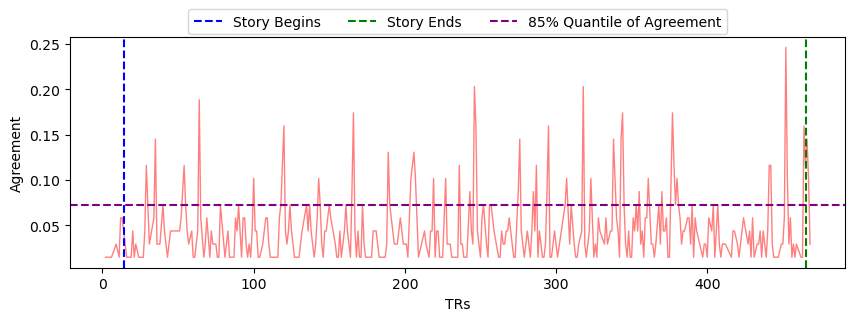

In [22]:
# make a scatter plot with line
# agreement is the y axis
# TR is the x axis
fig, ax1 = plt.subplots(figsize=(10, 3))
# ax1.scatter(response_df['TR'], response_df['agreement'], color='r', s=1, alpha=0.5)
ax1.plot(response_df_correct['TR'], response_df_correct['agreement'], color='r', linewidth=1, alpha=0.5)
ax1.set_xlabel("TRs")
ax1.set_ylabel("Agreement")
ax1.axvline(x=14, color='b', linestyle='--', label="Story Begins")
ax1.axvline(x=465, color='g', linestyle='--', label="Story Ends")
th = response_df_correct['agreement'].quantile(0.85)
ax1.axhline(y=th, color='purple', linestyle='--', label="85% Quantile of Agreement")
# add label to the legend
ax1.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=3)
plt.show()

## Now we/I want to modify Sebastian's method

What was Sebastian's method?
- He calculated the ratio of raters that marked an event boundary within every second in the story.

Why we need to modify it?
- Behavioral data (key response) can be delayed even if our brain realizes there is a boundary.

How to modify it?
- Theoretically, the logic is that, given the definition of EST, an event boundary should be more likely to occur at the beginning or the end of a sentence, or where there is a pause (e.g., comma) in the speech, rather than in the middle of a sentence. 
- Methodologically, we want to examine each key response timepoint (TR), and check whether it is close to a boundary (e.g., beginning or end of a sentence, or where there is a pause in the speech) of a previous sentence within a given threshold delta. If yes, we record this sentence boundarytimepoint (TR) for this key response. If no, we ignore this key response.

In [42]:
seg_df = pd.read_csv(os.path.join(stimuli_dir, "segments_speaker.csv"), encoding='ISO-8859-1')
# now get the onset_sec of that row if the last element of the seg is a period or question mark or a quotation mark
# sentence_onsets = []
# for idx, row in seg_df.iterrows():
#     seg = row['seg']
#     if seg[-1] == '.' or seg[-1] == '?' or seg[-1] == '"':
#         sentence_onsets.append(row['onset_sec'])
seg_df['onset_TRs'] = seg_df['onset_sec'].apply(lambda x: seconds2TRs(x+21)[0])
sentence_onset_TRs = np.unique(seg_df['onset_TRs'].tolist())

In [24]:
def filter_elements(A, list_B, delta=3):
    # Find the position where element A would fit in the sorted list
    pos = bisect_left(list_B, A)
    
    # If A is out of bounds of list_B, return None
    if pos == 0 or pos == len(list_B):
        return None
    
    # Identify closest elements to A in list_B
    B = list_B[pos]
    B_prev = list_B[pos - 1]
    
    # Identify next closest elements if they exist
    B_next = list_B[pos + 1] if pos + 1 < len(list_B) else float('inf')
    
    # Filtering conditions
    if A == B:
        return B
    elif B_prev <= A <= min(B_prev + delta, B):
        return B_prev
    elif B <= A <= min(B + delta, B_next):
        return B
    else:
        return None

In [25]:
response_df_correct['filtered_TRs'] = response_df_correct['TR'].apply(lambda x: filter_elements(x, sentence_onset_TRs))

In [26]:
# now we need to get a new list of TRs
all_filtered_TRs = []
for idx, row in response_df_correct.iterrows():
    if row['filtered_TRs'] is not None:
        # we want to append row['filtered_TRs'] row['count'] times into all_filtered_TRs
        for i in range(np.int(row['count'])):
            all_filtered_TRs.append(row['filtered_TRs'])

all_filtered_TRs = np.array(all_filtered_TRs)

# Count the occurrences of each unique element
filtered_response_counts = Counter(all_filtered_TRs)
# Create a new DataFrame
response_df_filtered = pd.DataFrame(list(filtered_response_counts.items()), columns=['TR', 'count'])
# drop nan based on TR
response_df_filtered = response_df_filtered.dropna(subset=['TR'])
# Sort by TR for better readability
response_df_filtered = response_df_filtered.sort_values(by='TR').reset_index(drop=True)
response_df_filtered['agreement'] = response_df_filtered['count'] / correct_subjs.shape[0]

In [27]:
response_df_filtered.describe()

TR       count   agreement
count  165.000000  165.000000  165.000000
mean   239.969697    6.630303    0.096091
std    128.219582    5.866632    0.085024
min     14.000000    1.000000    0.014493
25%    126.000000    3.000000    0.043478
50%    235.000000    5.000000    0.072464
75%    354.000000    8.000000    0.115942
max    463.000000   30.000000    0.434783

In [28]:
th = response_df_filtered['agreement'].quantile(0.85)
response_df_filtered[response_df_filtered['agreement'] > th]

TR  count  agreement
4     34.0     16   0.231884
9     53.0     19   0.275362
12    63.0     20   0.289855
39   118.0     27   0.391304
40   122.0     13   0.188406
43   135.0     13   0.188406
45   141.0     13   0.188406
56   165.0     21   0.304348
72   206.0     21   0.304348
86   245.0     30   0.434783
97   275.0     21   0.304348
104  294.0     19   0.275362
108  307.0     14   0.202899
111  317.0     20   0.289855
113  323.0     12   0.173913
119  338.0     24   0.347826
120  343.0     27   0.391304
126  359.0     15   0.217391
130  370.0     16   0.231884
131  377.0     12   0.173913
132  378.0     13   0.188406
155  440.0     19   0.275362
159  452.0     26   0.376812

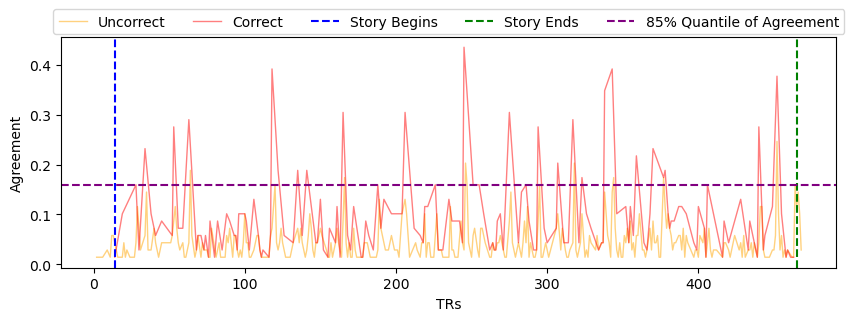

In [29]:
# make a scatter plot with line
# agreement is the y axis
# TR is the x axis
fig, ax1 = plt.subplots(figsize=(10, 3))
# ax1.scatter(response_df['TR'], response_df['agreement'], color='r', s=1, alpha=0.5)
ax1.plot(response_df_correct['TR'], response_df_correct['agreement'], color='orange', linewidth=1, alpha=0.5, label="Uncorrect")
ax1.plot(response_df_filtered['TR'], response_df_filtered['agreement'], color='r', linewidth=1, alpha=0.5, label="Correct")
ax1.set_xlabel("TRs")
ax1.set_ylabel("Agreement")
ax1.axvline(x=14, color='b', linestyle='--', label="Story Begins")
ax1.axvline(x=465, color='g', linestyle='--', label="Story Ends")
th = response_df_filtered['agreement'].quantile(0.85)
ax1.axhline(y=th, color='purple', linestyle='--', label="85% Quantile of Agreement")
# add label to the legend and put the legend to the center
ax1.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=5)
plt.show()

In [30]:
# Initialize an empty dictionary to store the results
threshold_dict = {}

# Loop through thresholds from 0.5 to 0.99, increasing by 0.01 each time
for percentile in [x / 100 for x in range(50, 100)]:
    # Get the number of rows that meet the condition
    th = response_df_filtered['agreement'].quantile(percentile)
    num_rows = response_df_filtered[response_df_filtered['agreement'] > th].shape[0]
    
    # Add the result to the dictionary
    threshold_dict[percentile] = num_rows

# Convert the dictionary to a DataFrame
threshold_df = pd.DataFrame(list(threshold_dict.items()), columns=['Threshold', 'Count'])

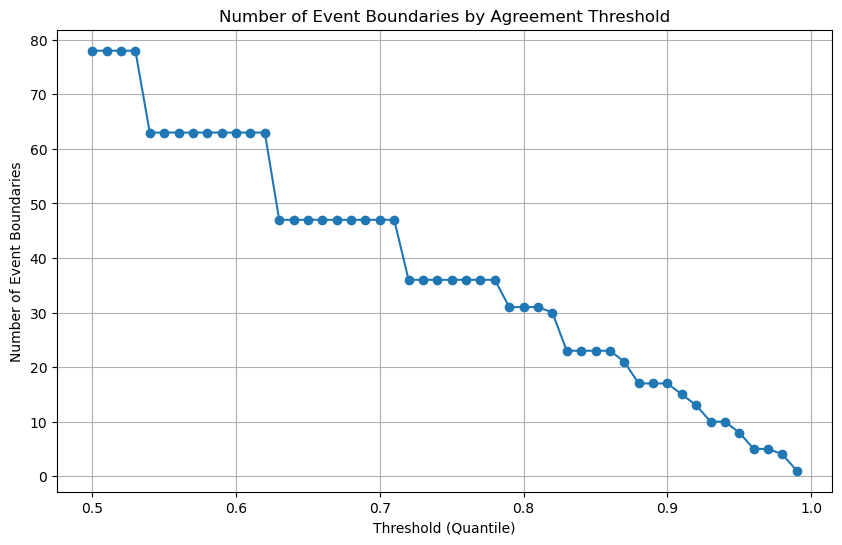

In [31]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(threshold_df['Threshold'], threshold_df['Count'], marker='o')
plt.xlabel('Threshold (Quantile)')
plt.ylabel('Number of Event Boundaries')
plt.title('Number of Event Boundaries by Agreement Threshold')
plt.grid(True)
plt.show()

## Get event segments

In [58]:
th = response_df_filtered['agreement'].quantile(0.85)
boundaries = response_df_filtered[response_df_filtered['agreement'] > th]['TR'].tolist()
# add the end as the last element
boundaries.append(465.0)

In [59]:
seg_df

seg  onset_sec   speaker  \
0    When the phone rang, the gray-haired man asked...        0.0  narrator   
1    The girl heard him as if from a distance, and ...        7.5  narrator   
2            The grayhaired man asked her to hurry up,       20.9  narrator   
3    and she raised up on her right forearm just qu...       23.5  narrator   
4    She cleared her hair back from her forehead wi...       29.8  narrator   
..                                                 ...        ...       ...   
174  He picked a burning cigaretteÑthe girl'sÑout o...      661.0  narrator   
175                but it slipped out of his fingers.       665.5  narrator   
176  The girl tried to help him retrieve it before ...      667.3  narrator   
177  but he told her to just sit still, for Chrissake,      670.2  narrator   
178                      and she pulled back her hand.      673.5  narrator   

         actor main_char  section  onset_TRs  
0    lee, girl       lee      NaN       14.0  
1         girl      girl      NaN       19.0  
2    lee, girl       lee      NaN       28.0  
3         girl      girl      NaN       30.0  
4         girl      girl      NaN       34.0  
..         ...       ...      ...        ...  
174       lee       lee       NaN      455.0  
175        lee       lee      NaN      458.0  
176  girl, lee      girl      NaN      459.0  
177        lee       lee      NaN      461.0  
178       girl      girl      NaN      463.0  

[179 rows x 7 columns]

In [60]:
for i, r in enumerate(boundaries):  # Removed extra comma
    if i == 0:  # First iteration
        seg_index = seg_df[seg_df['onset_TRs'] == r].index[-1]
        seg = seg_df.iloc[:seg_index]['seg'].tolist()
    elif i == len(boundaries) - 1:  # Last iteration
        prev_r = boundaries[i-1]
        prev_seg_index = seg_df[seg_df['onset_TRs'] == prev_r].index[-1]
        seg = seg_df.iloc[prev_seg_index:]['seg'].tolist()
    else:  # Subsequent iterations
        prev_r = boundaries[i-1]
        prev_seg_index = seg_df[seg_df['onset_TRs'] == prev_r].index[-1]
        seg_index = seg_df[seg_df['onset_TRs'] == r].index[-1]
        seg = seg_df.iloc[prev_seg_index:seg_index]['seg'].tolist()
    print(i, r, seg, "\n")

0 34.0 ["When the phone rang, the gray-haired man asked the girl, with quite some little deference, if she would rather for any reason he didn't answer it. ", 'The girl heard him as if from a distance, and turned her face toward him, one eyeÑon the side of the lightÑclosed tight, her open eye very, however disingenuously, large, and so blue as to appear almost violet.', 'The grayhaired man asked her to hurry up,', "and she raised up on her right forearm just quickly enough so that the movement didn't quite look perfunctory."] 

1 53.0 ['She cleared her hair back from her forehead with her left hand ', 'and said, "God. I don\'t know. I mean what do you think?" ', "The gray-haired man said he didn't see that it made a helluva lot of difference one way or the other, ", "and slipped his left hand under the girl's supporting arm, above the elbow, working his fingers up, making room for them between the warm surfaces of her upper arm and chest wall.", 'He reached for the phone with his right

In [62]:
# save list to file
filepath = os.path.join(data_dir, "event_boundaries.txt")
with open(filepath, "w") as f:
    for item in boundaries:
        f.write("%s\n" % item)